In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import magic
import os 
import umap
import statistics
from scipy.stats import spearmanr
import harmonypy as hm
from sklearn.cluster import KMeans, AgglomerativeClustering
import sklearn.decomposition as skd
from sklearn.metrics import silhouette_score, adjusted_rand_score, v_measure_score
import matplotlib.pyplot as plt
import scanpy as sc
import optuna

In [2]:
# set seed
np.random.seed(127)

# Step 0: Download the training data

In [3]:
# get current path 
path_data = os.getcwd() 

### Training data information

In [4]:
bulk_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_bulk_train.csv")).set_index("level_0")

In [5]:
print(f"Number of patients in the train dataset {bulk_pancreas.shape[1]}")
print(f"Number of genes in the dataset {bulk_pancreas.shape[0]}")

Number of patients in the train dataset 4
Number of genes in the dataset 25453


In [6]:
sc_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_train.csv")).set_index("Unnamed: 0")

In [7]:
assert bulk_pancreas.shape[0] == sc_pancreas.shape[0]
print(f"Number of cells in the train dataset {sc_pancreas.shape[1]}")

Number of cells in the train dataset 978


In [8]:
sc_pancreas_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_test.csv")).set_index("Unnamed: 0")

In [9]:
print(f"Number of cells in the test dataset {sc_pancreas_test.shape[1]}")

Number of cells in the test dataset 789


In [10]:
sc_pancreas_metadata = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_metadata_train.csv")).set_index("Source Name")

In [11]:
for patient in sc_pancreas_metadata.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata[sc_pancreas_metadata.Sample==patient].shape[0]}")

Number of cells for patient1 is 249
Number of cells for patient3 is 219
Number of cells for patient2 is 234
Number of cells for patient4 is 276


In [12]:
for dis in sc_pancreas_metadata.Disease.unique():
    df = sc_pancreas_metadata[sc_pancreas_metadata.Disease==dis]
    print(f"There are {df.Sample.nunique()} train patients with {dis}")

There are 2 train patients with type II diabetes mellitus
There are 2 train patients with normal


In [13]:
print(f"There are {df.Celltype.nunique()} different cell types in the dataset")
print(f"The different cells types are {df.Celltype.unique()}")

There are 11 different cell types in the dataset
The different cells types are ['delta cell' 'alpha cell' 'beta cell' 'PSC cell' 'endothelial cell'
 'gamma cell' 'co-expression cell' 'ductal cell' 'epsilon cell'
 'unclassified endocrine cell' 'acinar cell']


In [14]:
sc_pancreas_metadata.Celltype.nunique()

13

### Test data information

In [15]:
sc_pancreas_metadata_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_metadata_test_wocelltype.csv")).set_index("Source Name")

In [16]:
for patient in sc_pancreas_metadata_test.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata_test[sc_pancreas_metadata_test.Sample==patient].shape[0]}")

Number of cells for patient5 is 203
Number of cells for patient7 is 284
Number of cells for patient6 is 302


In [17]:
for dis in sc_pancreas_metadata_test.Disease.unique():
    df = sc_pancreas_metadata_test[sc_pancreas_metadata_test.Disease==dis]
    print(f"There are {df.Sample.nunique()} test patients with {dis}")

There are 1 test patients with normal
There are 2 test patients with type II diabetes mellitus


Dropout in Single cell data: When a gene is observed at a moderate or high expression level in one cell but not detected in another cell. An expressed transcript is not detected. 
- reasons for dropout: biological, or non-biological. 
- biological: indicates information about cell states
- non-biological: technical zeros, which occur during the preparation of biological samples for sequencing, and sampling zeros, which arise due to limited sequencing depths

Good imputation methods for single cell data
- should achieve: 
1. accurate estimation of missing values
- should avoid: 
1. overfitting or oversmoothing: could lead to loss of biological information or variability 
2. loss of sparsity

Samples  processed by different technicians and/or at different time points could lead to batch effect
- how batch effect may affect single cell data: could lead to variation in sample groups that are caused by technical arrangements rather than biological factors, which could lead to false conclusions 
- methods to overcome potentially confounding effects: eliminate technical noise or bias so that observed variance in gene expression variance primarily reflects true biological variance.
- use some batch correction algorithms: ex: MNN, CCA, Harmony 


# Step 1: Perform the imputation

Methods to try for imputation 
- MAGIC
- ZINB VAE AND ZINB CVAE helps impute dropout effect

- calculating the "bulkified" data means calculating the patient-wide average of gene expression (ex: avg SGIP1 exp for patient1, 2, 3, 4)
- To get the gene expression for patient j, you must simply average the library size-corrected values of the gene expression over all cells of the same patient.
- average spearman's correlation will be calculated for all patients in the test set 

In [18]:
def bulkification(sc_data):
    patient_ids = sorted(list(set([col.split('_')[0] for col in sc_data.columns])))
    bulkified = pd.DataFrame(columns=patient_ids, index=sc_data.index)
    for patient_id in patient_ids:
        # Select columns belonging to the same patient
        patient_columns = [col for col in sc_data.columns if col.startswith(patient_id)]
        patient_data = sc_data[patient_columns]
        
        # Calculate the mean expression for each gene for the current patient
        mean_expression = patient_data.mean(axis=1)
        bulkified[patient_id] = mean_expression
    return bulkified

In [19]:
def calc_spearman(log_transformed_bulk_data, bulkified):
    patient_ids = sorted(list(set([col.split('_')[0] for col in bulkified.columns])))
    spearman_correlations = []
    for patient_id in patient_ids:
        spearman_correlation = spearmanr(log_transformed_bulk_data[patient_id], bulkified[patient_id])[0]
        spearman_correlations.append(spearman_correlation)
    return spearman_correlations

In [20]:
# TODO: findtune parameters for MAGIC, see if you can improve the results, could also do preprocessing (normalization)
magic_operator = magic.MAGIC()
sc_pancreas_imputed = magic_operator.fit_transform(sc_pancreas)


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.93 seconds.
    Calculating KNN search...
    Calculated KNN search in 66.14 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 26935 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 63.83 seconds.
  Calculated graph and diffusion operator in 133.98 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 1.30 seconds.
Calculated MAGIC in 135.34 seconds.


In [21]:
# bulkifying and calculating spearman correlation
bulkified_train = bulkification(sc_pancreas_imputed)
log_transformed_bulk_data = np.log2(bulk_pancreas + 1)
spearman_correlations = calc_spearman(log_transformed_bulk_data, bulkified_train)
print(statistics.mean(spearman_correlations))

0.9373493905297718


In [22]:
# attempting optimization 
def objective(trial, sc_pancreas, bulk_pancreas):
    # Suggest values for parameters
    knn = trial.suggest_int("knn", 3, 15)
    decay = trial.suggest_float("decay", 1, 10, log=True)
    t = trial.suggest_int("t", 1, 10)
    n_pca = trial.suggest_int("n_pca", 10, 200)

    # Initialize MAGIC with suggested parameters
    magic_operator = magic.MAGIC(
        knn=knn, decay=decay, t=t, n_pca=n_pca
    )

    # Perform imputation
    sc_pancreas_imputed = magic_operator.fit_transform(sc_pancreas)

    # Bulkify and calculate Spearman correlation
    bulkified_train = bulkification(sc_pancreas_imputed)
    log_transformed_bulk_data = np.log2(bulk_pancreas + 1)
    spearman_correlations = calc_spearman(log_transformed_bulk_data, bulkified_train)

    # Return the negative mean Spearman correlation (Optuna minimizes the objective)
    return -statistics.mean(spearman_correlations)

In [23]:
# concatenate columns of sc_pancreas and sc_pancreas_test together according to index
sc_pancreas_train_test = pd.concat([sc_pancreas, sc_pancreas_test], axis=1, join='inner')

# normalization
sc_pancreas_imputed_train_test_ad = sc.AnnData(sc_pancreas_train_test.T)
sc.pp.normalize_total(sc_pancreas_imputed_train_test_ad, target_sum=1e4)

# filter for genes that are not expressed in any cell
filtgene = sc.pp.filter_genes(sc_pancreas_imputed_train_test_ad, inplace=False, min_cells= 3)
filtcell = sc.pp.filter_cells(sc_pancreas_imputed_train_test_ad, inplace=False, min_genes= 200)

sc_pancreas_train_test_norm = pd.DataFrame(sc_pancreas_imputed_train_test_ad.X.T,
                                                    columns= sc_pancreas_train_test.columns,
                                                    index= sc_pancreas_train_test.index)

filtered = sc_pancreas_train_test_norm.loc[filtgene[0], :]
filtered = filtered.loc[:, filtcell[0]]

filtered_out = sc_pancreas_train_test_norm.loc[~filtgene[0], :]

# magic imputation on filtered data
magic_operator = magic.MAGIC()
sc_pancreas_train_test_norm_filt_magic = magic_operator.fit_transform(filtered.T).T

# add back in genes that were filtered out because they were false in filtgene[0]
sc_pancreas_train_test_norm_filt_magic = sc_pancreas_train_test_norm_filt_magic.set_index(filtered.index)
sc_pancreas_train_test_norm_filt_magic = pd.concat([sc_pancreas_train_test_norm_filt_magic, filtered_out], axis= 0, join= 'inner')

# order the columns of sc_pancreas_train_test_norm_filt_magic to match sc_pancreas_train_test_norm
sc_pancreas_train_test_norm_filt_magic = sc_pancreas_train_test_norm_filt_magic.loc[sc_pancreas_train_test_norm.index,:]

# check if columns are the same
assert(sc_pancreas_train_test_norm_filt_magic.index == sc_pancreas_train_test_norm.index).all()
assert(sc_pancreas_train_test_norm_filt_magic.columns == sc_pancreas_train_test_norm.columns).all()

# select out for test data 
sc_pancreas_all_imp = sc_pancreas_train_test_norm_filt_magic[sc_pancreas.columns]
sc_pancreas_all_imp_bulk = bulkification(sc_pancreas_all_imp)
spearman_all = calc_spearman(log_transformed_bulk_data, sc_pancreas_all_imp_bulk)
print(statistics.mean(spearman_all))

# from now on for imputed data use sc_pancreas_all_imp


Calculating MAGIC...
  Running MAGIC on 1767 cells and 20640 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 7.68 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.26 seconds.
    Calculating affinities...
    Calculated affinities in 0.17 seconds.
  Calculated graph and diffusion operator in 8.16 seconds.
  Running MAGIC with `solver='exact'` on 20640-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 1.67 seconds.
Calculated MAGIC in 9.92 seconds.
0.9525105353655948


In [24]:
# Create a study and optimize the parameters using Optuna
study = optuna.create_study()
study.optimize(lambda trial: objective(trial, filtered.T, bulk_pancreas), n_trials=100)

# Print the best parameters and the corresponding mean Spearman correlation
print("Best parameters:", study.best_params)
print("Best mean Spearman correlation:", -study.best_value)

[I 2023-04-28 13:46:34,900] A new study created in memory with name: no-name-b072ab58-a8de-41ea-b865-9bad65e91efc


Calculating MAGIC...
  Running MAGIC on 1767 cells and 20640 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 9.76 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.39 seconds.
    Calculating affinities...
    Calculated affinities in 0.16 seconds.
  Calculated graph and diffusion operator in 10.36 seconds.
  Running MAGIC with `solver='exact'` on 20640-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 1.04 seconds.
Calculated MAGIC in 11.67 seconds.


[W 2023-04-28 14:21:37,157] Trial 0 failed with parameters: {'knn': 9, 'decay': 9.334730245408437, 't': 4, 'n_pca': 152} because of the following error: KeyError('A1BG').
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3361, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 76, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 108, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'A1BG'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/op

KeyError: 'A1BG'

In [ ]:
# commenting out for now bc we decided to use both train/test and filtered
'''
# best magic with "best parameters" found with optuna 
best_magic_operator = magic.MAGIC() 
sc_pancreas_imputed_best = best_magic_operator.fit_transform(sc_pancreas.T).T

# bulkifying and calculating spearman correlation
# before bulkifying, normalize gene expression with library size

sc_pancreas_imputed_best_ad = sc.AnnData(sc_pancreas_imputed_best.T)
sc.pp.normalize_total(sc_pancreas_imputed_best_ad, target_sum=1e4)
sc_pancreas_imputed_best_norm = pd.DataFrame(sc_pancreas_imputed_best_ad.X.T, 
                                        columns= sc_pancreas_imputed_best.columns,
                                        index= sc_pancreas_imputed_best.index)


best_bulkified_train = bulkification(sc_pancreas_imputed_best)
log_transformed_bulk_data = np.log2(bulk_pancreas + 1)
best_spearman_correlations = calc_spearman(log_transformed_bulk_data, best_bulkified_train)
print(statistics.mean(best_spearman_correlations))

'''


# Step 2: Perform clustering 

- clustering output can be performed on raw/imputed counts
- free to do whatever transformations on data

Batch correction methods
- regression based methods (ComBat)
- dimensionality reduction methods (Harmony, Seurat, iNMF)
- deep learning based models (BERMUDA, scVI, scVAE)

--> trying out LIGER, Harmony, Seurat 

### Parameters that could be tuned
- which preprocessing pipeline to use 
- whether to include harmony batch correction or not 
- which leiden resolution to use to obtain clusters

In [ ]:
# calcluating scores 
def cluster_scoring(adata, leiden_res, sc_metadata):
    labels = adata.obs[leiden_res]
    # only select labels that have indices corresponding to sc_pancreas column name
    # make sure labels.index in sc_pancreas.columns
    # adding in this line bc we are using both train and test 
    labels = labels.loc[sc_pancreas.columns]

    ari = adjusted_rand_score(sc_metadata.Celltype, labels)
    v_measure = v_measure_score(sc_metadata.Celltype, labels)
    # TODO: not sure if ssc is accurate 
    adata_umap = adata.obsm["X_umap"]
    # pca on the umap
    adata_pca = skd.PCA(n_components=50).fit_transform(adata_umap)

    ssc = silhouette_score(adata.obsm["X_pca"][0:978,:], labels)
    # avg is the average of ari and v_measure
    avg = (ari + v_measure + ssc)/3
    print(f"resolution: {leiden_res}, ARI: {ari}, V-measure: {v_measure}, Silhouette score: {ssc}, Average: {avg}")
    return avg, ssc
    

In [ ]:
def perform_clustering(adata, sc_pancreas_metadata, use_recipe, use_harmony_pca, leiden_resolution):
    # Create a copy of the input data to avoid modifying the original
    adata_copy = adata.copy()

    # Perform batch correction using Seurat recipe or basic preprocessing
    if use_recipe == 'seurat':
        sc.pp.recipe_seurat(adata_copy)
    elif use_recipe == 'zheng':
        # TODO: could consider differnet number of top genes
        sc.pp.recipe_zheng17(adata_copy, log = True, n_top_genes= 3000)
    elif use_recipe == 'basic':
        sc.pp.filter_genes(adata_copy, min_cells=3)
        sc.pp.normalize_total(adata_copy, target_sum=1e4)
        sc.pp.log1p(adata_copy)
        sc.pp.highly_variable_genes(adata_copy, min_mean=0.0125, max_mean=3, min_disp=0.5)
        adata_copy = adata_copy[:, adata_copy.var['highly_variable']]
        sc.pp.scale(adata_copy, max_value=10)
    elif use_recipe == 'weinreb':
        sc.pp.recipe_weinreb17(adata_copy, log = False)
    elif use_recipe == 'None':
        pass
    else:
        raise ValueError('Invalid recipe specified')
    
    # Calculate nearest neighbors
    sc.pp.neighbors(adata_copy, use_rep='X')
    # sc.tl.umap(adata_copy)

    if type(leiden_resolution) == list:
        for lr in leiden_resolution:
            leiden_key = 'leiden_res_raw' + str(lr)
            sc.tl.leiden(adata_copy, key_added = leiden_key, resolution=lr)
    else:
        leiden_key = 'leiden_res_raw' + str(leiden_resolution)
        sc.tl.leiden(adata_copy, key_added = leiden_key, resolution=leiden_resolution)

    
    # Perform PCA (this will be default X_pca if harmony not used)
    sc.tl.pca(adata_copy, n_comps= 50)
    
    # adding in cell type information
    if 'Celltype' in sc_pancreas_metadata.columns:
        adata_copy.obs['Celltype'] = sc_pancreas_metadata.Celltype

    # Use Harmony for batch-corrected PCA if requested
    if use_harmony_pca:
        harmony_pcs = hm.run_harmony(data_mat = adata_copy.obsm['X_pca'],
                                     meta_data = sc_pancreas_metadata,
                                     vars_use = ['Sample'],
                                     max_iter_harmony= 20, verbose=False
                                     )
        adata_copy.obsm['X_pca'] = harmony_pcs.Z_corr.T
    
    # Calculate nearest neighbors
    sc.tl.umap(adata_copy, n_components=50)
    # uncomment line below if you want to use umap as rep 
    # sc.pp.neighbors(adata_copy, n_pcs= 50, use_rep='X_umap')
    sc.pp.neighbors(adata_copy)
    

    # Perform Leiden clustering with specified resolution
    if type(leiden_resolution) == list:
        for lr in leiden_resolution:
            leiden_key = 'leiden_res_pc' + str(lr)
            sc.tl.leiden(adata_copy, key_added = leiden_key, resolution=lr)
    else:
        leiden_key = 'leiden_res_pc' + str(leiden_resolution)
        sc.tl.leiden(adata_copy, key_added = leiden_key, resolution=leiden_resolution)
    

    return adata_copy

Performing clustering with impute= True, recipe=seurat, harmony_pca=True


2023-04-28 01:34:05,146 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-28 01:34:06,424 - harmonypy - INFO - sklearn.KMeans initialization complete.


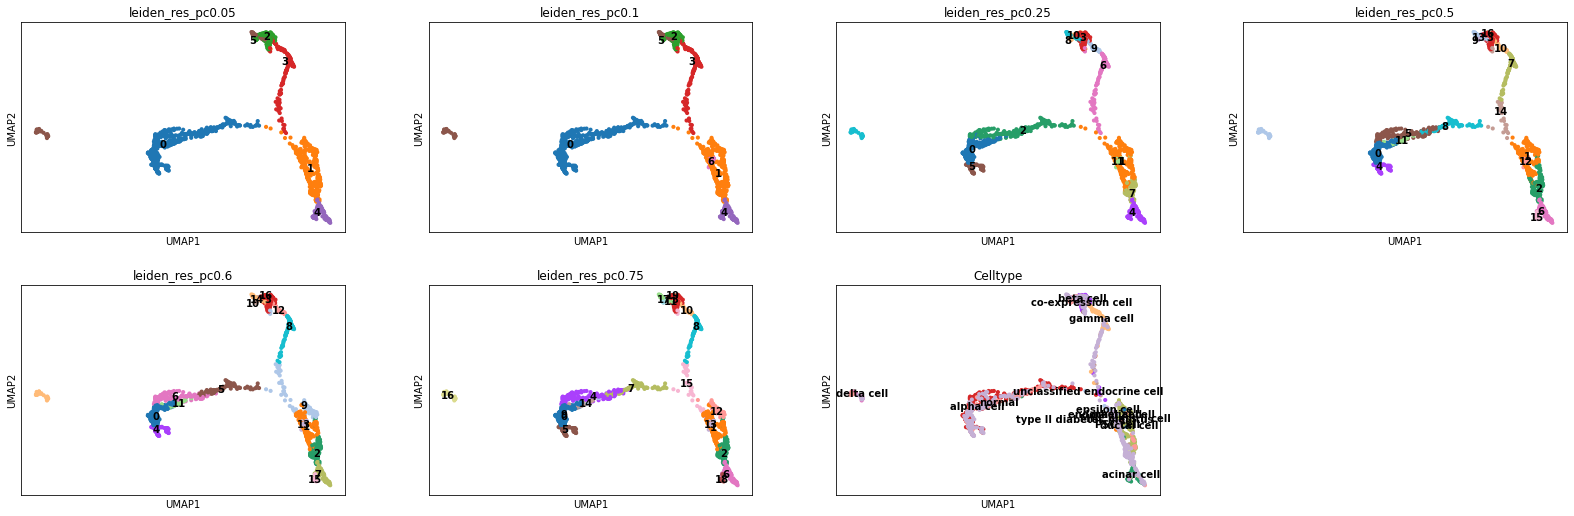

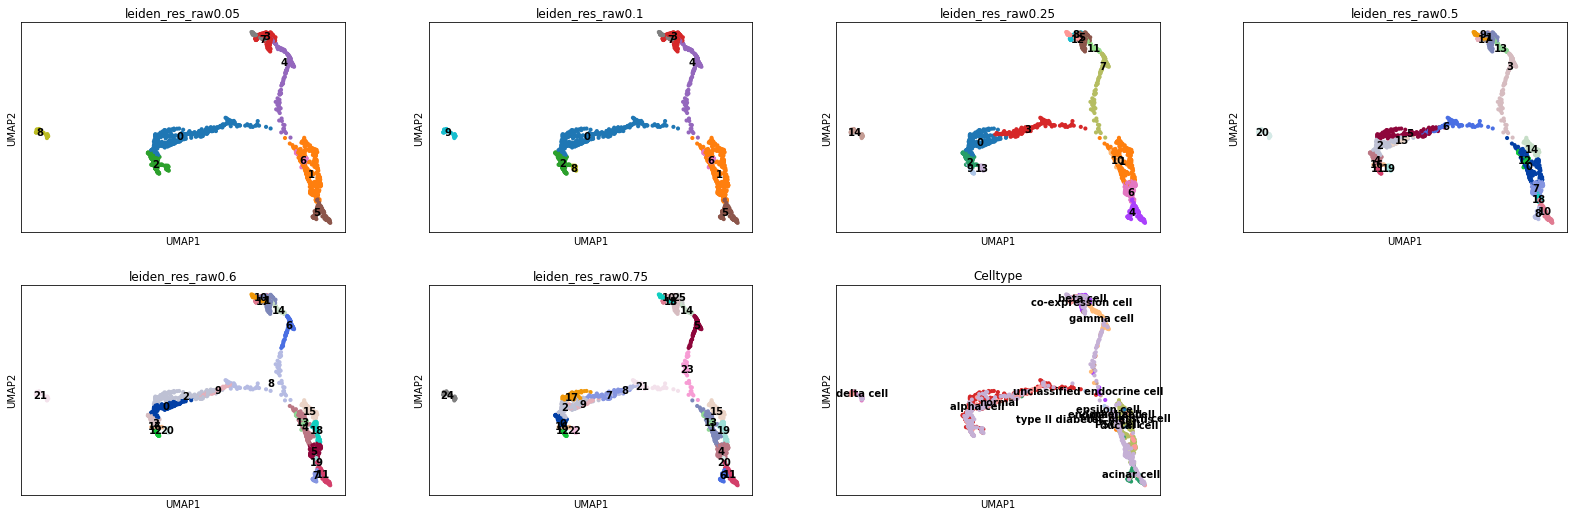

resolution: leiden_res_pc0.05, ARI: 0.877897006821484, V-measure: 0.8409771206240273, Silhouette score: 0.4643542170524597, Average: 0.7277427814993237
resolution: leiden_res_pc0.1, ARI: 0.9032365994717941, V-measure: 0.8625493614481334, Silhouette score: 0.5227587223052979, Average: 0.7628482277417419
resolution: leiden_res_pc0.25, ARI: 0.506575065340376, V-measure: 0.7381743710079952, Silhouette score: 0.20045235753059387, Average: 0.4817339312929884
resolution: leiden_res_pc0.5, ARI: 0.4050535765428386, V-measure: 0.7064184959029782, Silhouette score: 0.2145637422800064, Average: 0.4420119382419411
resolution: leiden_res_pc0.6, ARI: 0.3826812940088855, V-measure: 0.6907152901276078, Silhouette score: 0.20594042539596558, Average: 0.42644566984415294
resolution: leiden_res_pc0.75, ARI: 0.3573376316974519, V-measure: 0.6942613059291325, Silhouette score: 0.18718411028385162, Average: 0.412927682636812
Performing clustering with impute= True, recipe=seurat, harmony_pca=False


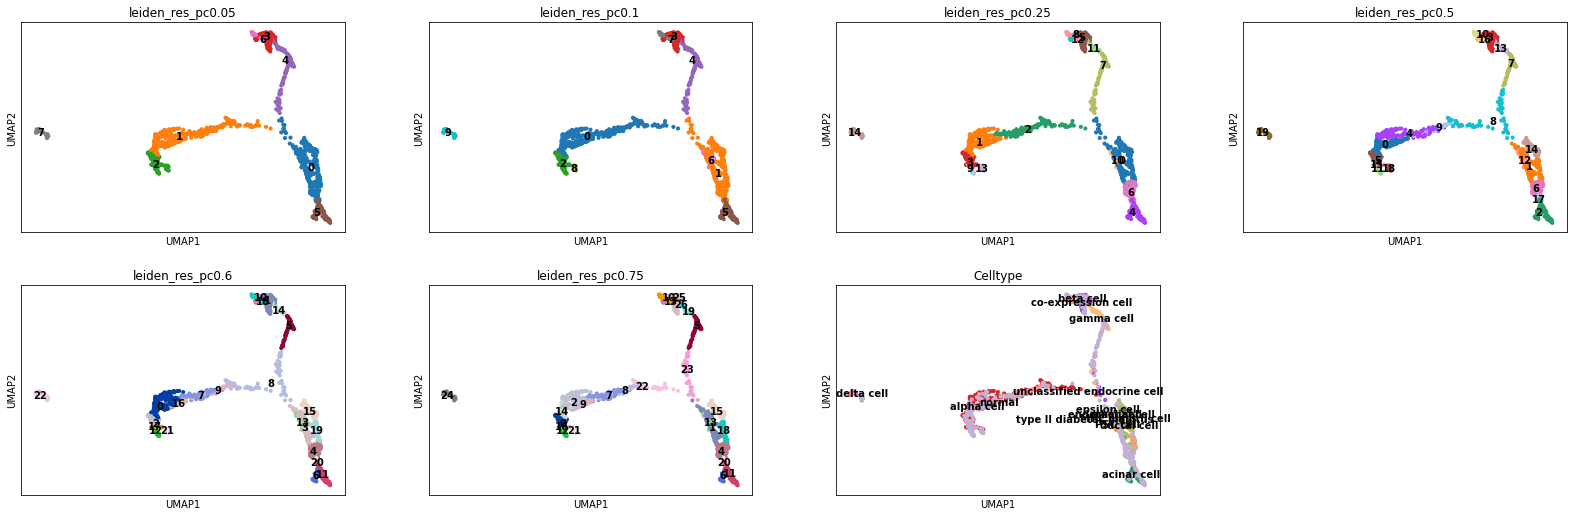

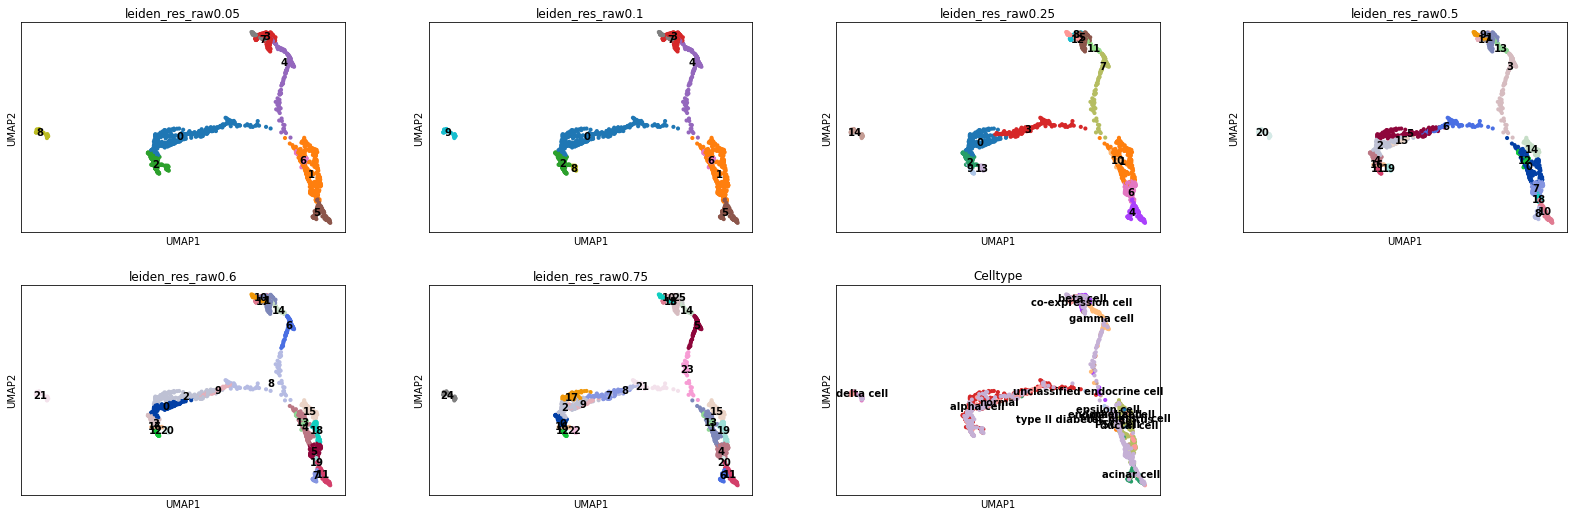

resolution: leiden_res_pc0.05, ARI: 0.6538051487491198, V-measure: 0.7779011292032806, Silhouette score: 0.272794634103775, Average: 0.5681669706853918
resolution: leiden_res_pc0.1, ARI: 0.6702316201512865, V-measure: 0.7948838168800614, Silhouette score: 0.2818773686885834, Average: 0.5823309352399771
resolution: leiden_res_pc0.25, ARI: 0.45806453044124246, V-measure: 0.7145514963330482, Silhouette score: 0.1954086273908615, Average: 0.4560082180550507
resolution: leiden_res_pc0.5, ARI: 0.34220527834357783, V-measure: 0.6753156526826515, Silhouette score: 0.24025526642799377, Average: 0.419258732484741
resolution: leiden_res_pc0.6, ARI: 0.3029580898372058, V-measure: 0.6600025129118962, Silhouette score: 0.24246062338352203, Average: 0.40180707537754135
resolution: leiden_res_pc0.75, ARI: 0.2512468406565454, V-measure: 0.6452403871127431, Silhouette score: 0.2740841507911682, Average: 0.39019045952015224
Performing clustering with impute= True, recipe=zheng, harmony_pca=True


2023-04-28 01:34:23,588 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-28 01:34:25,725 - harmonypy - INFO - sklearn.KMeans initialization complete.


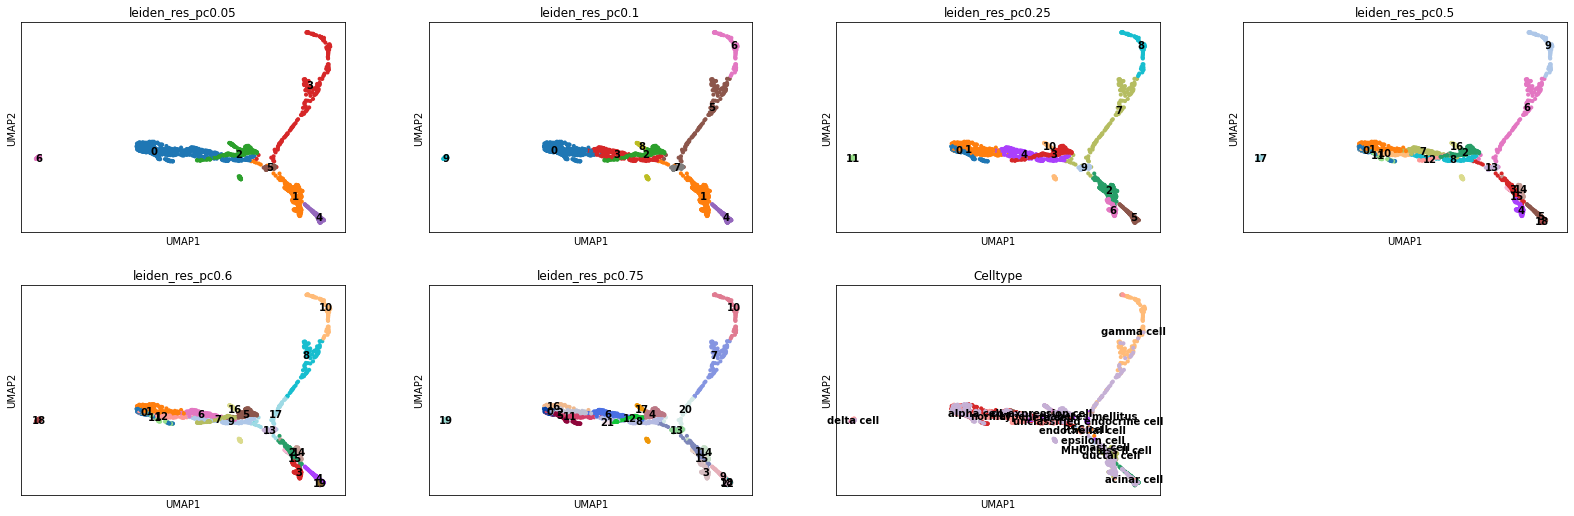

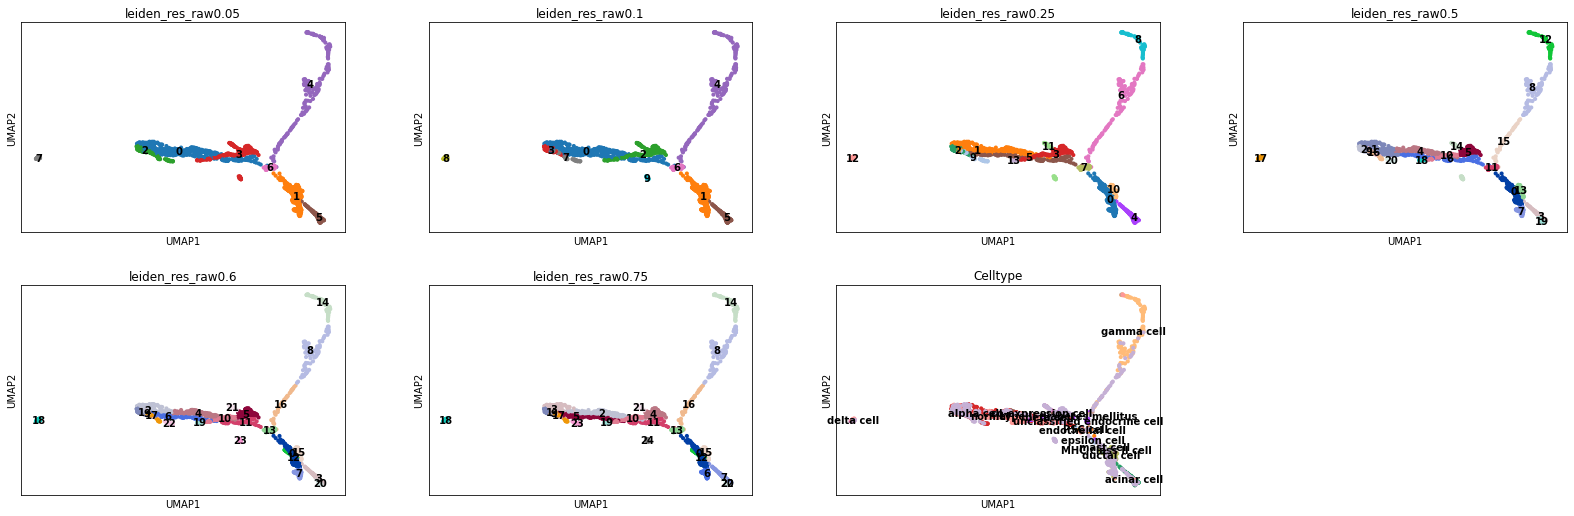

resolution: leiden_res_pc0.05, ARI: 0.8865421274093914, V-measure: 0.8415067509674258, Silhouette score: 0.509240984916687, Average: 0.7457632877645014
resolution: leiden_res_pc0.1, ARI: 0.6790747955250904, V-measure: 0.7854949223256201, Silhouette score: 0.4012186527252197, Average: 0.6219294568586434
resolution: leiden_res_pc0.25, ARI: 0.5025466201500819, V-measure: 0.7353533250527415, Silhouette score: 0.3100965917110443, Average: 0.515998845637956
resolution: leiden_res_pc0.5, ARI: 0.3443901943547927, V-measure: 0.674133654685734, Silhouette score: 0.2646271586418152, Average: 0.42771700256078066
resolution: leiden_res_pc0.6, ARI: 0.34461482260743276, V-measure: 0.6747873001455563, Silhouette score: 0.27747824788093567, Average: 0.4322934568779749
resolution: leiden_res_pc0.75, ARI: 0.2900137123876852, V-measure: 0.6589121537661676, Silhouette score: 0.28025466203689575, Average: 0.40972684273024956
Performing clustering with impute= True, recipe=zheng, harmony_pca=False


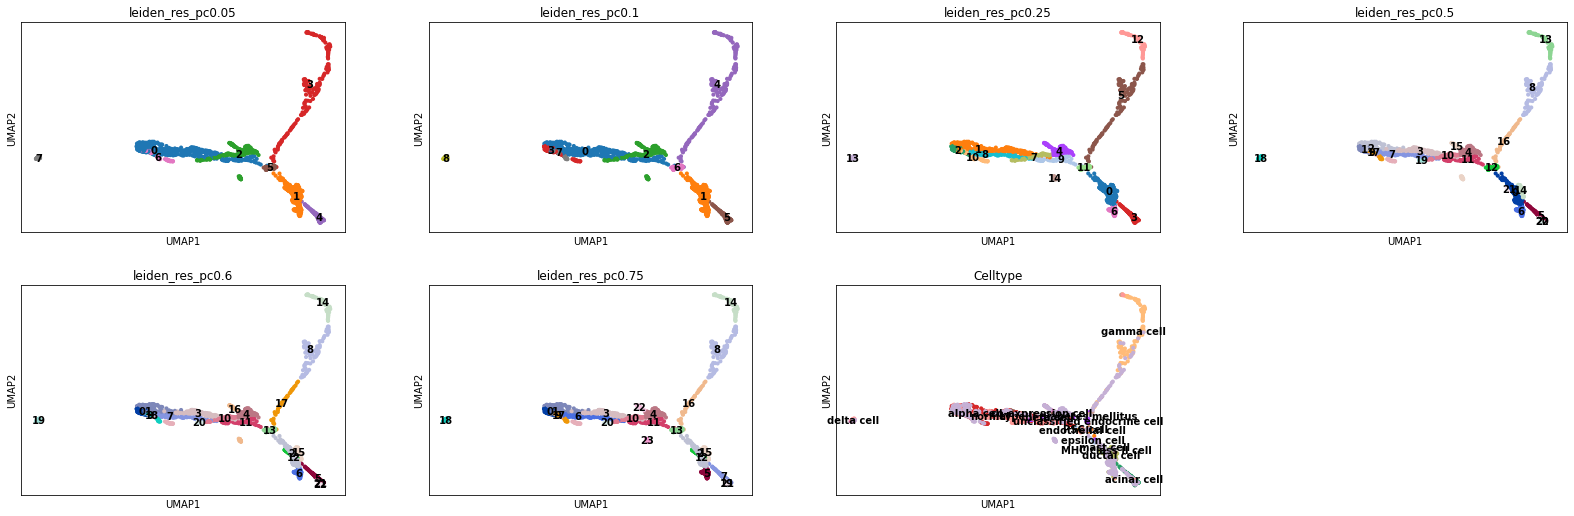

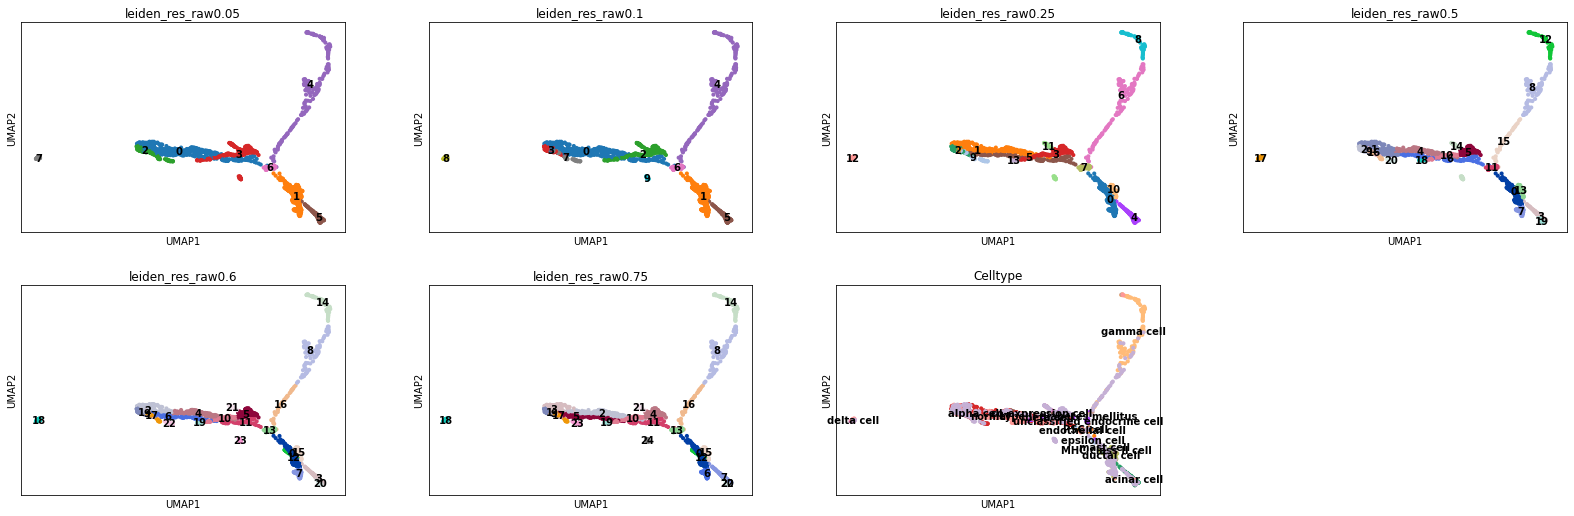

resolution: leiden_res_pc0.05, ARI: 0.8342899353560191, V-measure: 0.8325005951723485, Silhouette score: 0.30887800455093384, Average: 0.6585561783597672
resolution: leiden_res_pc0.1, ARI: 0.6727754946295289, V-measure: 0.7920198209659577, Silhouette score: 0.30386871099472046, Average: 0.589554675530069
resolution: leiden_res_pc0.25, ARI: 0.4619112192771998, V-measure: 0.7118397795492251, Silhouette score: 0.267113596200943, Average: 0.4802881983424559
resolution: leiden_res_pc0.5, ARI: 0.3206629256773084, V-measure: 0.6730169160198138, Silhouette score: 0.27036622166633606, Average: 0.4213486877878194
resolution: leiden_res_pc0.6, ARI: 0.32331823098260953, V-measure: 0.6760332597917248, Silhouette score: 0.27465736865997314, Average: 0.42466961981143586
resolution: leiden_res_pc0.75, ARI: 0.3087540092879502, V-measure: 0.6711654851841811, Silhouette score: 0.30372482538223267, Average: 0.4278814399514546
Performing clustering with impute= True, recipe=weinreb, harmony_pca=True


2023-04-28 01:34:44,121 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-28 01:34:45,145 - harmonypy - INFO - sklearn.KMeans initialization complete.


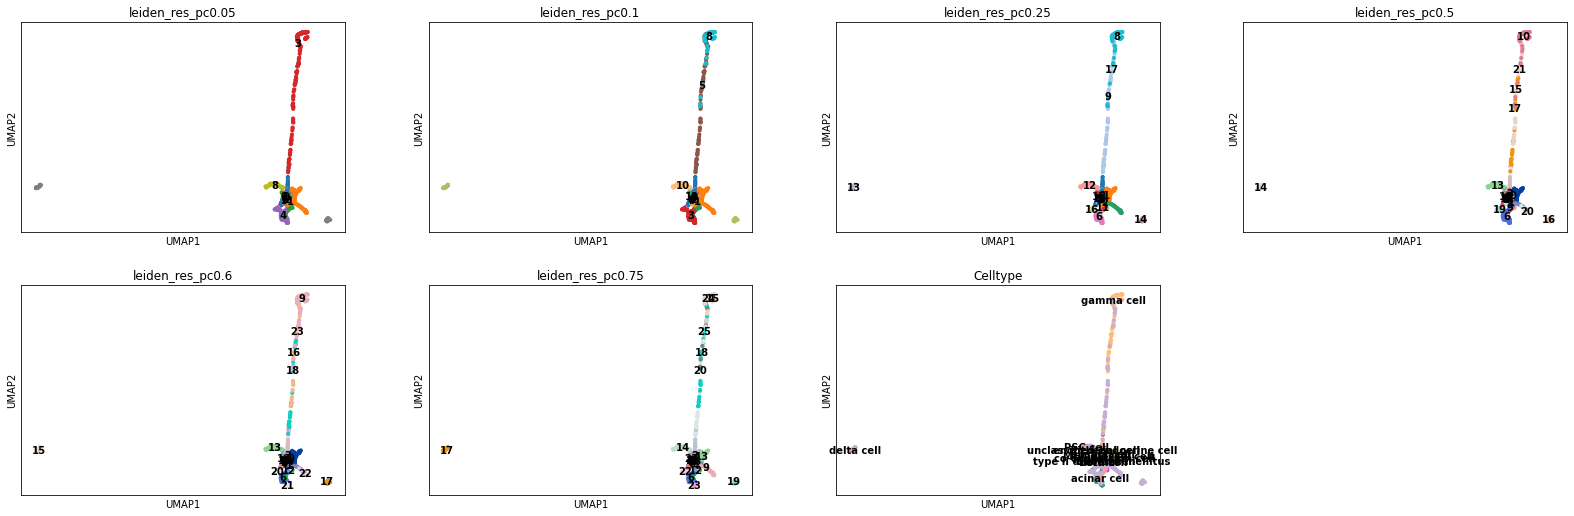

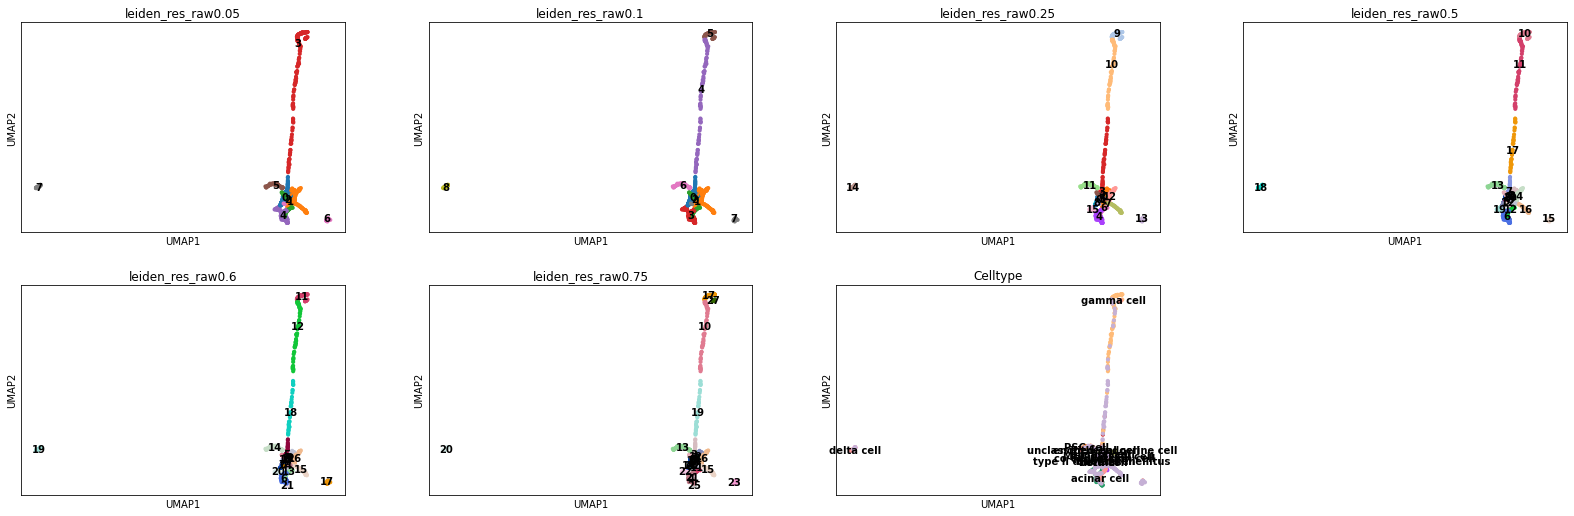

resolution: leiden_res_pc0.05, ARI: 0.8369001628519315, V-measure: 0.8366784323105958, Silhouette score: 0.15553778409957886, Average: 0.6097054597540353
resolution: leiden_res_pc0.1, ARI: 0.6888538863698371, V-measure: 0.7813497927688331, Silhouette score: 0.03396384045481682, Average: 0.501389173197829
resolution: leiden_res_pc0.25, ARI: 0.4574865173600298, V-measure: 0.7100966970352575, Silhouette score: 0.18500913679599762, Average: 0.45086411706376167
resolution: leiden_res_pc0.5, ARI: 0.39021689951626204, V-measure: 0.6880692619517184, Silhouette score: 0.25695672631263733, Average: 0.44508096259353924
resolution: leiden_res_pc0.6, ARI: 0.3643643315712479, V-measure: 0.6737412653138521, Silhouette score: 0.26181429624557495, Average: 0.4333066310435583
resolution: leiden_res_pc0.75, ARI: 0.3257407090763939, V-measure: 0.6579604663995674, Silhouette score: 0.29216405749320984, Average: 0.4252884109897237
Performing clustering with impute= True, recipe=weinreb, harmony_pca=False


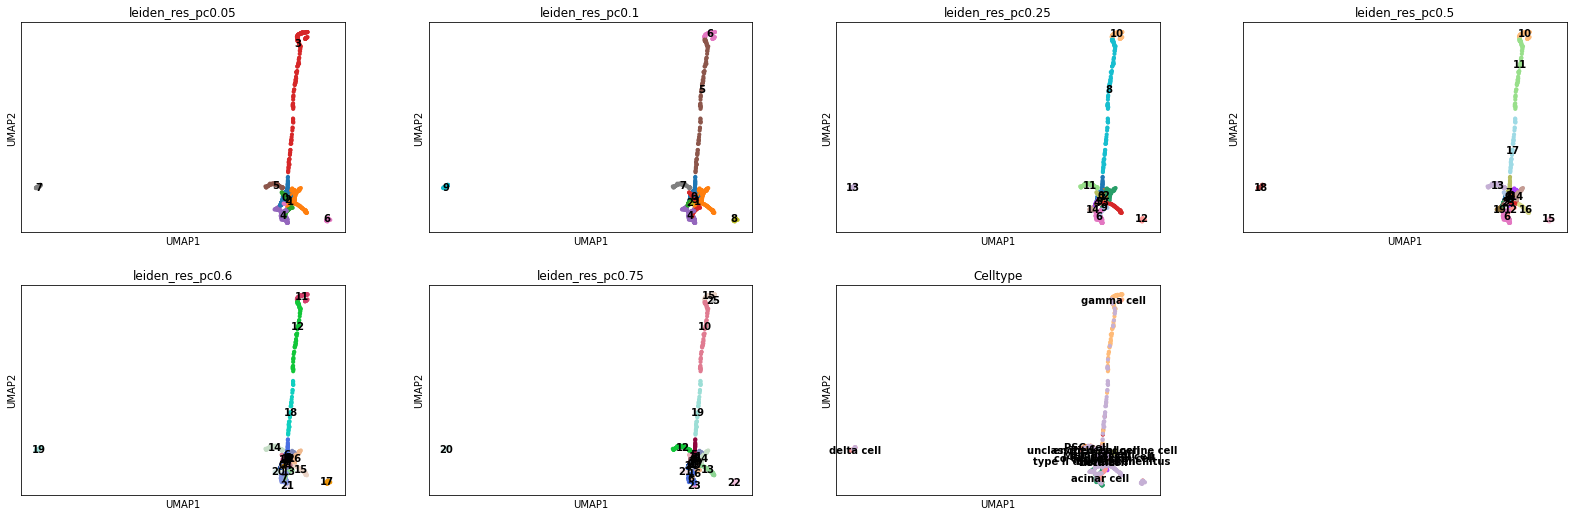

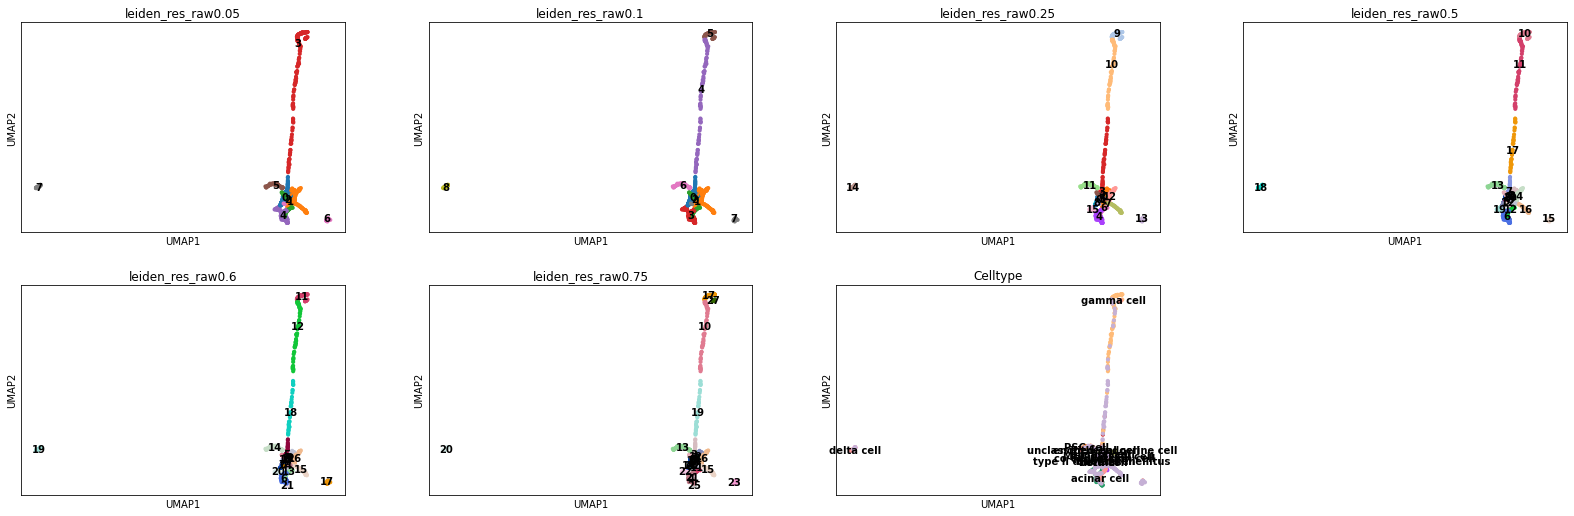

resolution: leiden_res_pc0.05, ARI: 0.8844115809890308, V-measure: 0.8563455802941522, Silhouette score: 0.3707355260848999, Average: 0.703830895789361
resolution: leiden_res_pc0.1, ARI: 0.6642848440399598, V-measure: 0.7852517764383085, Silhouette score: 0.03510759398341179, Average: 0.49488140482056003
resolution: leiden_res_pc0.25, ARI: 0.4364352994962448, V-measure: 0.7063237350972302, Silhouette score: 0.09909439831972122, Average: 0.4139511443043988
resolution: leiden_res_pc0.5, ARI: 0.3556976369084193, V-measure: 0.6791486427962526, Silhouette score: 0.17955568432807922, Average: 0.40480065467758375
resolution: leiden_res_pc0.6, ARI: 0.3031534808892424, V-measure: 0.6581544550836899, Silhouette score: 0.23025400936603546, Average: 0.3971873151129892
resolution: leiden_res_pc0.75, ARI: 0.28436797336278125, V-measure: 0.6461716844942693, Silhouette score: 0.24234701693058014, Average: 0.39096222492921023
Performing clustering with impute= True, recipe=basic, harmony_pca=True


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2023-04-28 01:35:03,440 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-28 01:35:04,172 - harmonypy - INFO - sklearn.KMeans initialization complete.


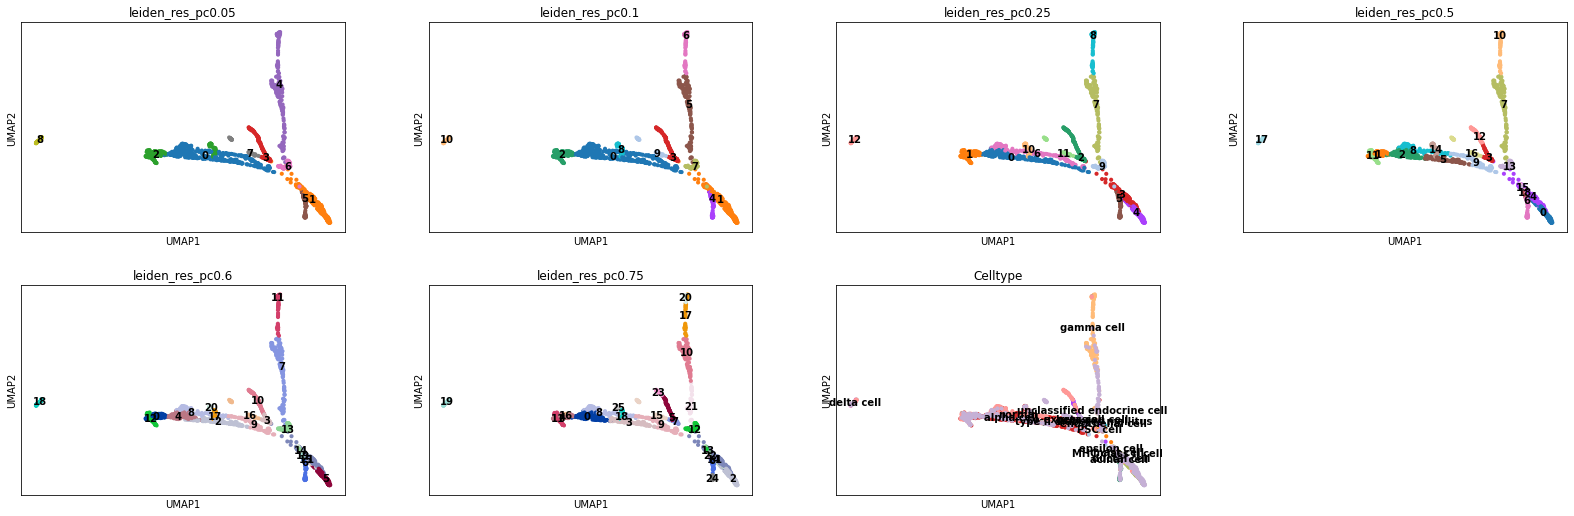

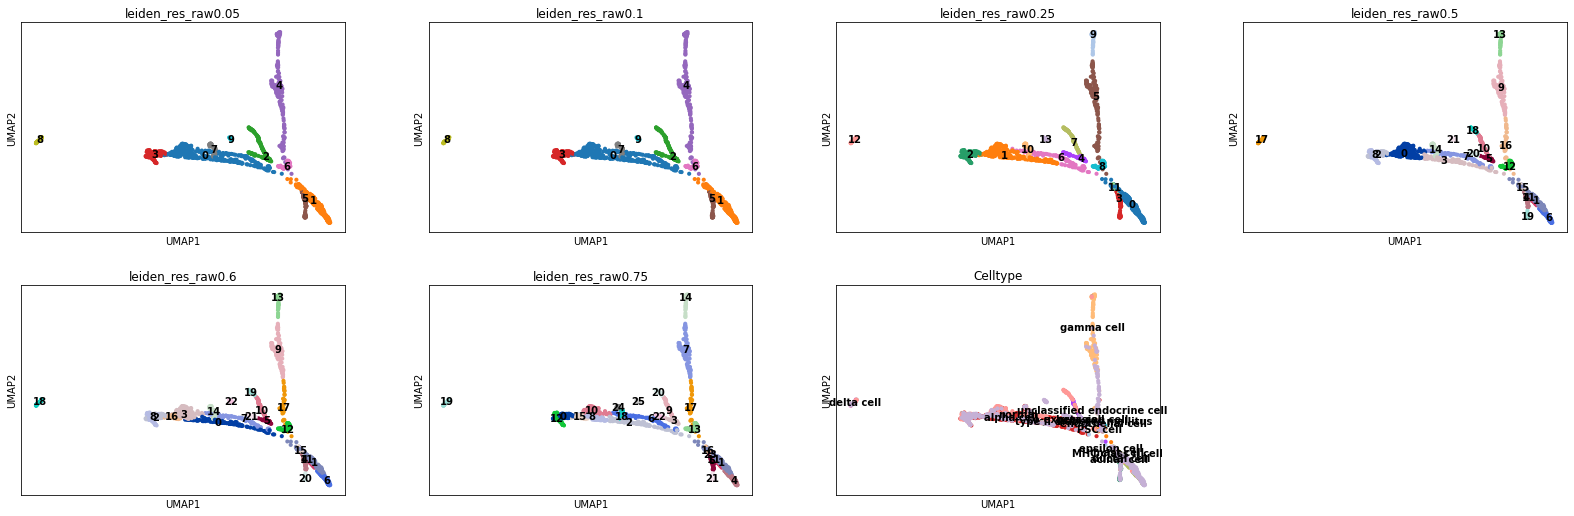

resolution: leiden_res_pc0.05, ARI: 0.6912391796074637, V-measure: 0.8119141461665844, Silhouette score: 0.36717212200164795, Average: 0.6234418159252321
resolution: leiden_res_pc0.1, ARI: 0.6297450924880468, V-measure: 0.777148176537815, Silhouette score: 0.3527849018573761, Average: 0.5865593902944126
resolution: leiden_res_pc0.25, ARI: 0.4822326523610861, V-measure: 0.7329058599645238, Silhouette score: 0.2939009368419647, Average: 0.5030131497225249
resolution: leiden_res_pc0.5, ARI: 0.33341842323881954, V-measure: 0.6784331474466729, Silhouette score: 0.2591753602027893, Average: 0.4236756436294273
resolution: leiden_res_pc0.6, ARI: 0.30873010943576223, V-measure: 0.6642831403087369, Silhouette score: 0.2672039270401001, Average: 0.41340572559486644
resolution: leiden_res_pc0.75, ARI: 0.27360698109005327, V-measure: 0.6506137002606969, Silhouette score: 0.2942723333835602, Average: 0.4061643382447701
Performing clustering with impute= True, recipe=basic, harmony_pca=False


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


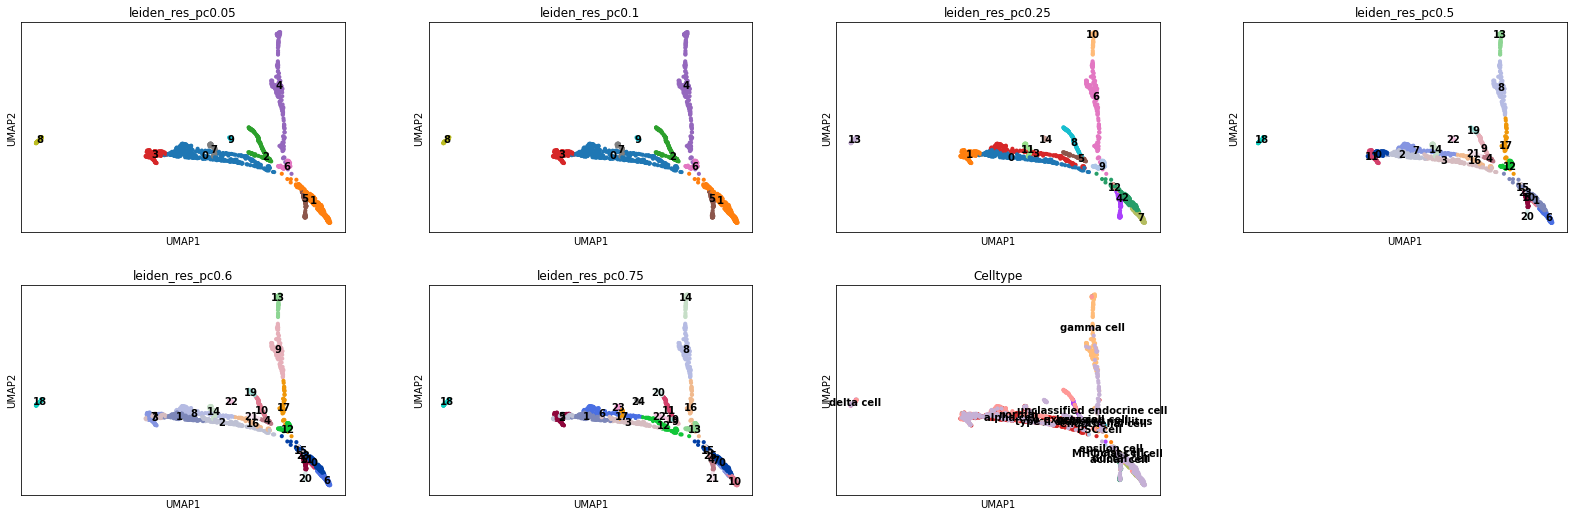

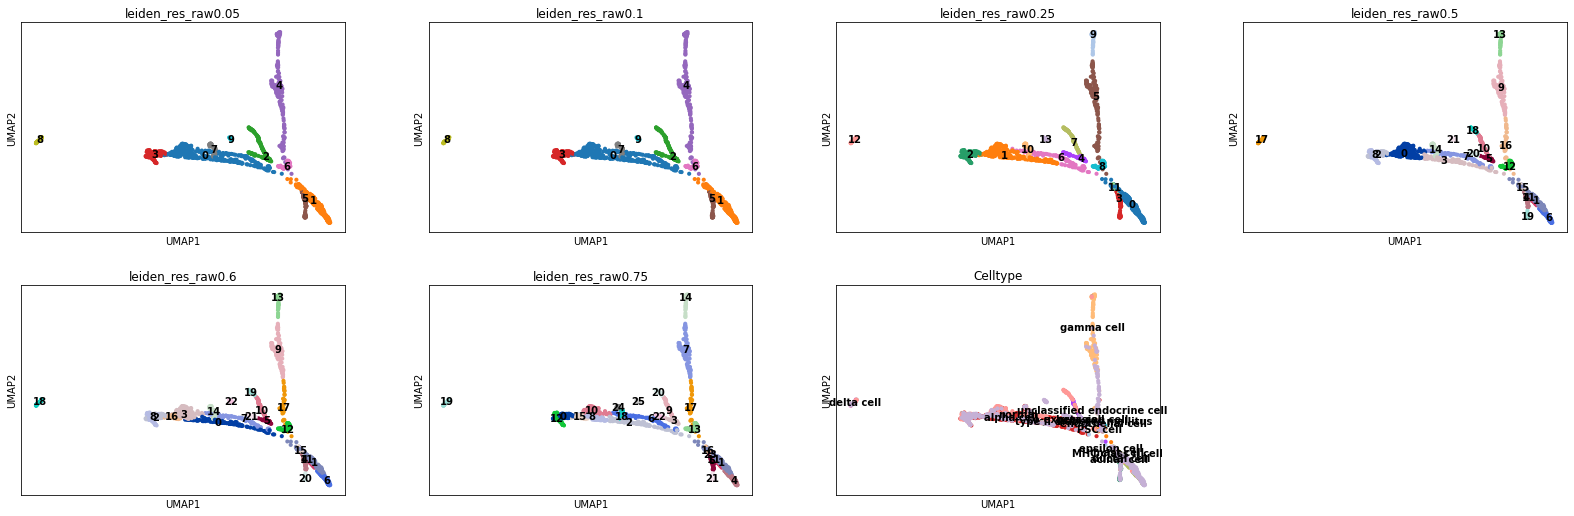

resolution: leiden_res_pc0.05, ARI: 0.6626841007022756, V-measure: 0.7899342208852098, Silhouette score: 0.3010253310203552, Average: 0.5845478842026135
resolution: leiden_res_pc0.1, ARI: 0.6626841007022756, V-measure: 0.7899342208852098, Silhouette score: 0.3010253310203552, Average: 0.5845478842026135
resolution: leiden_res_pc0.25, ARI: 0.4553297329396085, V-measure: 0.7111870432090495, Silhouette score: 0.3041771650314331, Average: 0.490231313726697
resolution: leiden_res_pc0.5, ARI: 0.32736986521090716, V-measure: 0.6758857198980952, Silhouette score: 0.29062390327453613, Average: 0.43129316279451285
resolution: leiden_res_pc0.6, ARI: 0.3184686610047232, V-measure: 0.6734466848238243, Silhouette score: 0.2943996489048004, Average: 0.42877166491111596
resolution: leiden_res_pc0.75, ARI: 0.3218563362187835, V-measure: 0.671739590466106, Silhouette score: 0.28450846672058105, Average: 0.4260347978018235
Performing clustering with impute= True, recipe=None, harmony_pca=True


2023-04-28 01:35:26,423 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-28 01:35:28,139 - harmonypy - INFO - sklearn.KMeans initialization complete.


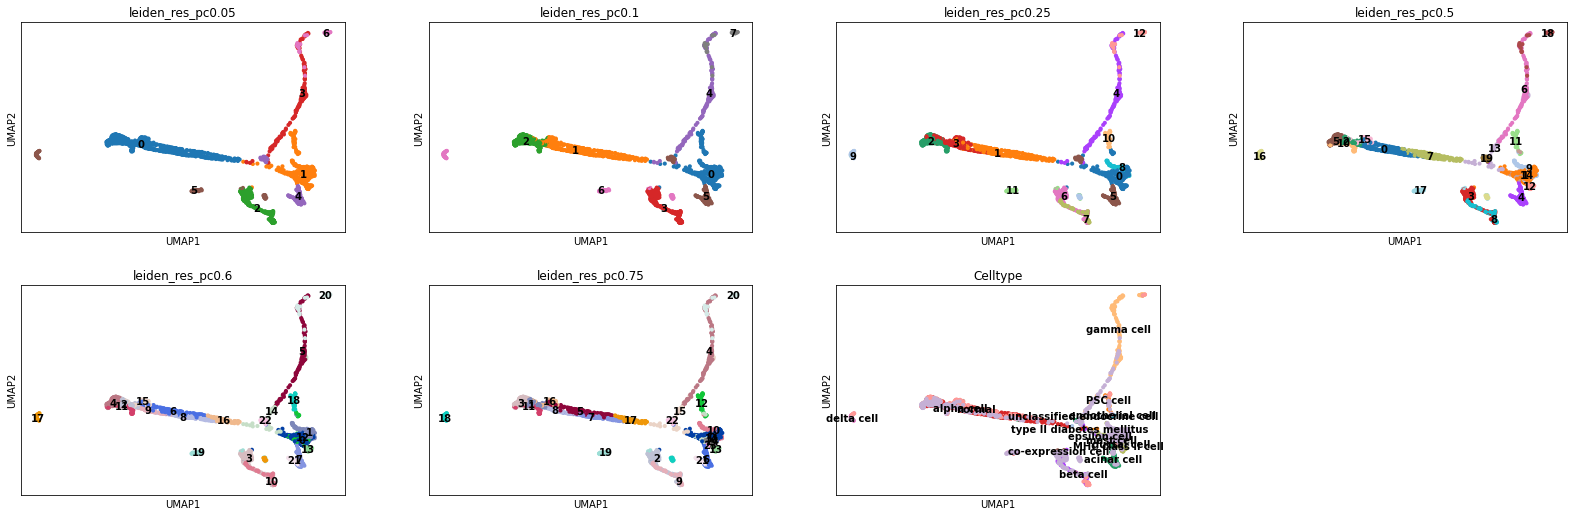

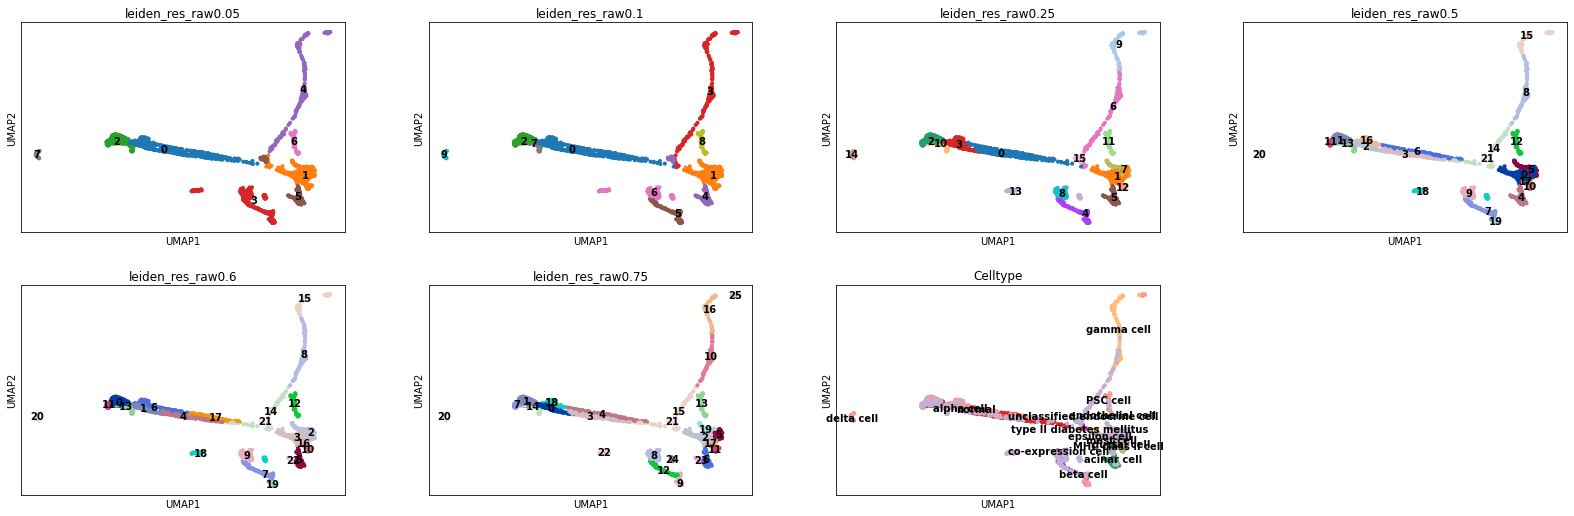

resolution: leiden_res_pc0.05, ARI: 0.8455703485316698, V-measure: 0.8123921081684575, Silhouette score: 0.4751538932323456, Average: 0.7110387833108244
resolution: leiden_res_pc0.1, ARI: 0.6108981579497416, V-measure: 0.7542389349272627, Silhouette score: 0.5126143097877502, Average: 0.6259171342215848
resolution: leiden_res_pc0.25, ARI: 0.4910262932212232, V-measure: 0.7211787618977186, Silhouette score: 0.42509135603904724, Average: 0.5457654703859963
resolution: leiden_res_pc0.5, ARI: 0.3756870773788963, V-measure: 0.6797946994890649, Silhouette score: 0.3254348337650299, Average: 0.4603055368776637
resolution: leiden_res_pc0.6, ARI: 0.29000699984981876, V-measure: 0.657200599506101, Silhouette score: 0.3548281788825989, Average: 0.43401192607950617
resolution: leiden_res_pc0.75, ARI: 0.28138073476239733, V-measure: 0.6495218239200659, Silhouette score: 0.3474593460559845, Average: 0.4261206349128159
Performing clustering with impute= True, recipe=None, harmony_pca=False


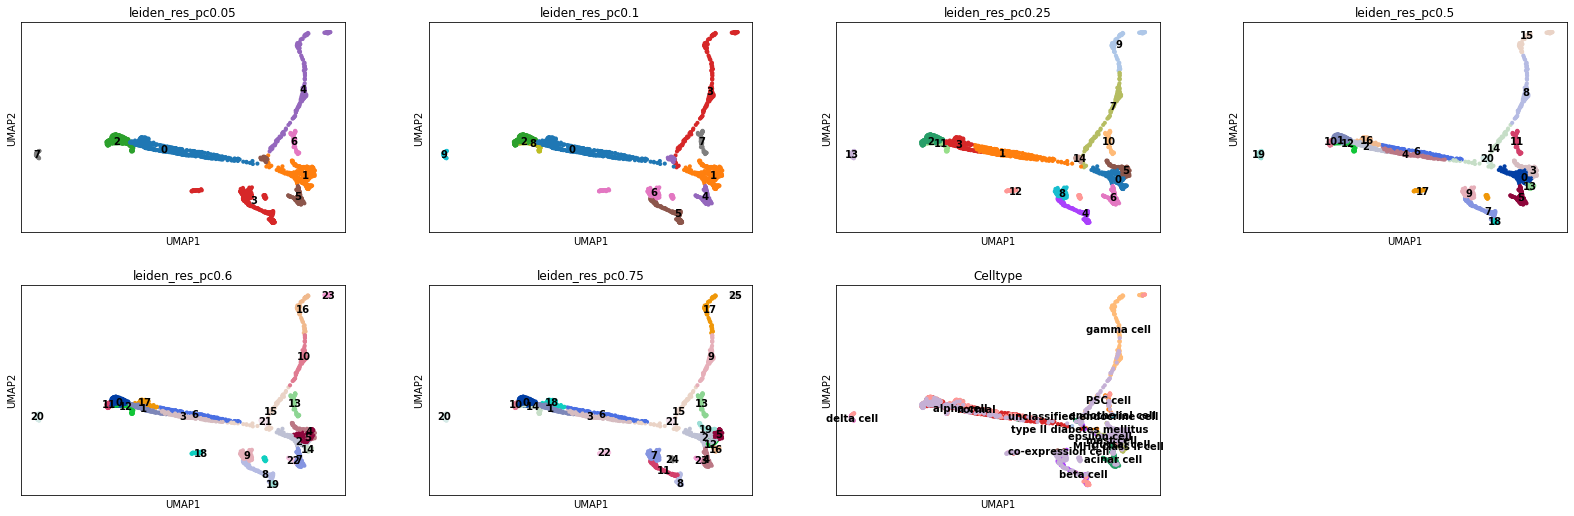

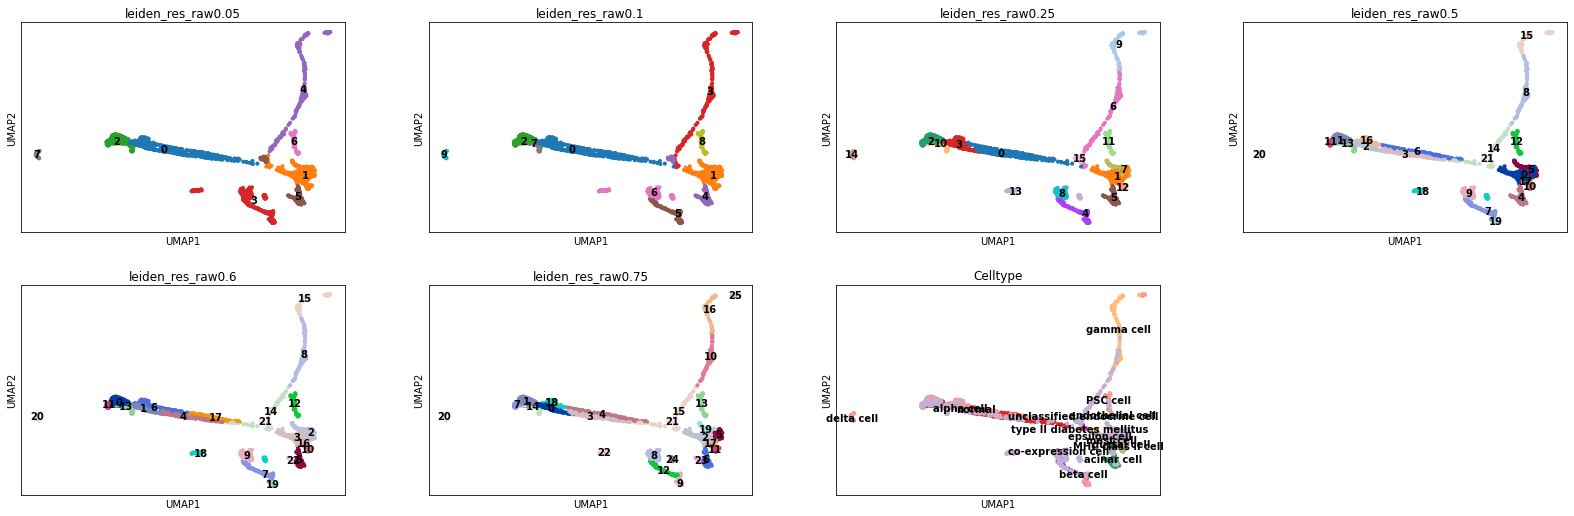

resolution: leiden_res_pc0.05, ARI: 0.6801260882356869, V-measure: 0.7969022949731173, Silhouette score: 0.37702345848083496, Average: 0.618017280563213
resolution: leiden_res_pc0.1, ARI: 0.6533584822023073, V-measure: 0.777065311963929, Silhouette score: 0.36225688457489014, Average: 0.5975602262470422
resolution: leiden_res_pc0.25, ARI: 0.46704820921148665, V-measure: 0.7189894459081023, Silhouette score: 0.3734751343727112, Average: 0.5198375964974334
resolution: leiden_res_pc0.5, ARI: 0.3385742676194721, V-measure: 0.6719633474708488, Silhouette score: 0.339433491230011, Average: 0.44999036877344395
resolution: leiden_res_pc0.6, ARI: 0.30950975424911475, V-measure: 0.659008757841266, Silhouette score: 0.3373972773551941, Average: 0.43530526314852497
resolution: leiden_res_pc0.75, ARI: 0.29125184486357714, V-measure: 0.6508823165925772, Silhouette score: 0.36770665645599365, Average: 0.436613605970716
Performing clustering with impute= False, recipe=seurat, harmony_pca=True


2023-04-28 01:35:46,860 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-28 01:35:48,284 - harmonypy - INFO - sklearn.KMeans initialization complete.


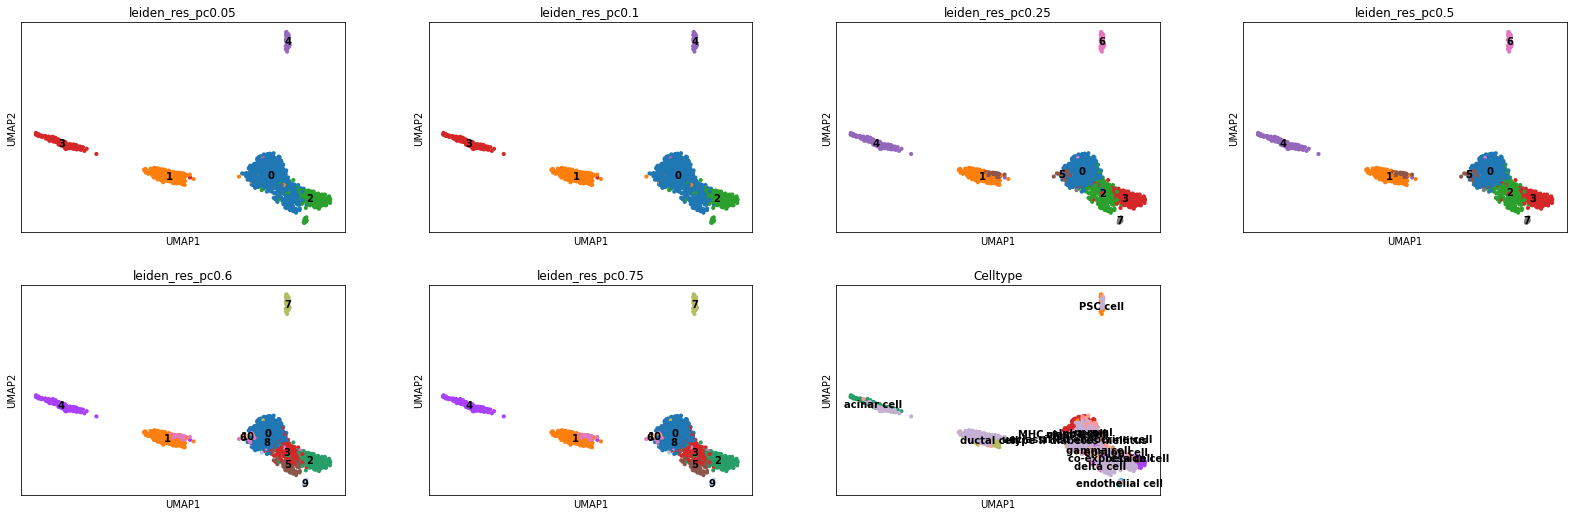

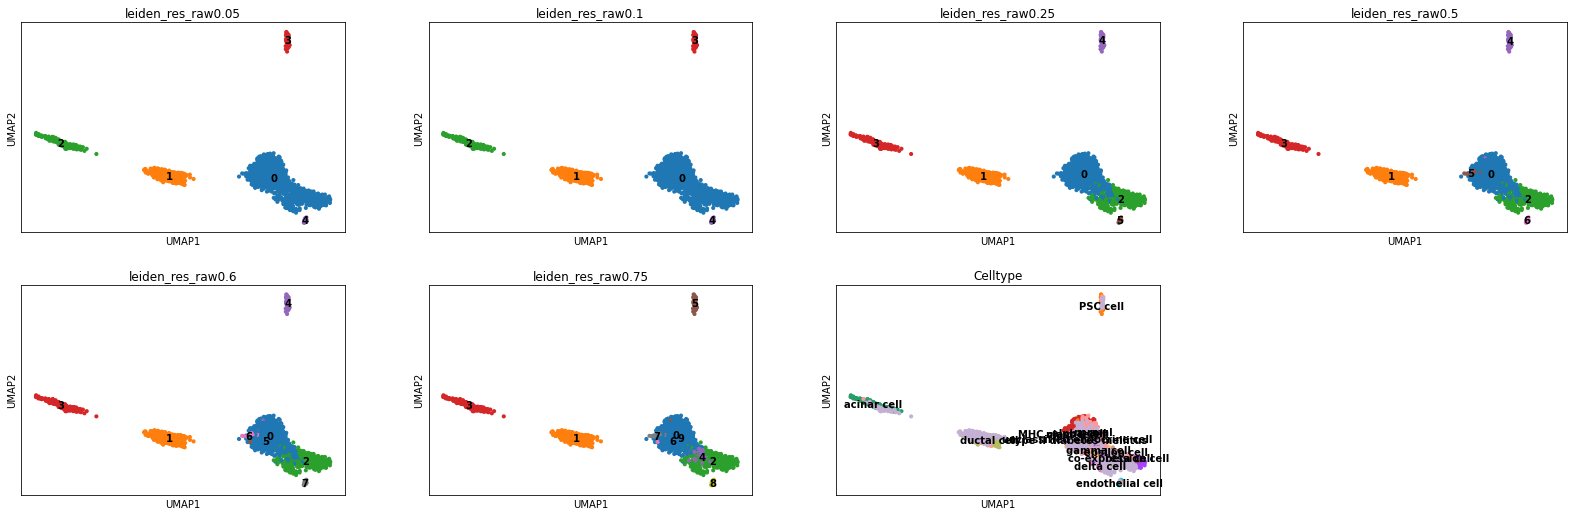

resolution: leiden_res_pc0.05, ARI: 0.6129908052293338, V-measure: 0.7623198560519792, Silhouette score: 0.2889293432235718, Average: 0.554746668168295
resolution: leiden_res_pc0.1, ARI: 0.6113474909196293, V-measure: 0.7589467231435016, Silhouette score: 0.28912004828453064, Average: 0.5531380874492206
resolution: leiden_res_pc0.25, ARI: 0.8285149792346683, V-measure: 0.8136534714398366, Silhouette score: 0.20251180231571198, Average: 0.6148934176634057
resolution: leiden_res_pc0.5, ARI: 0.8121694525198628, V-measure: 0.806145741666265, Silhouette score: 0.20252050459384918, Average: 0.606945232926659
resolution: leiden_res_pc0.6, ARI: 0.800911233633586, V-measure: 0.8037782315487942, Silhouette score: 0.18595252931118011, Average: 0.5968806648311867
resolution: leiden_res_pc0.75, ARI: 0.8056501425033087, V-measure: 0.8058998631017182, Silhouette score: 0.18666891753673553, Average: 0.5994063077139208
Performing clustering with impute= False, recipe=seurat, harmony_pca=False


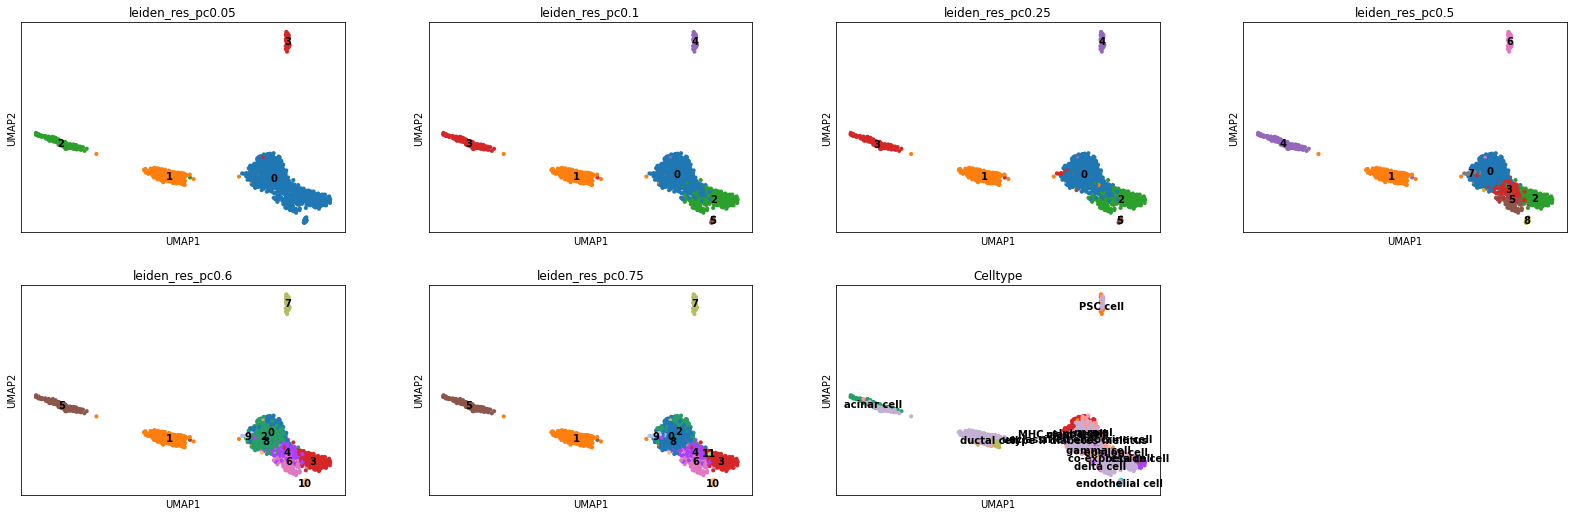

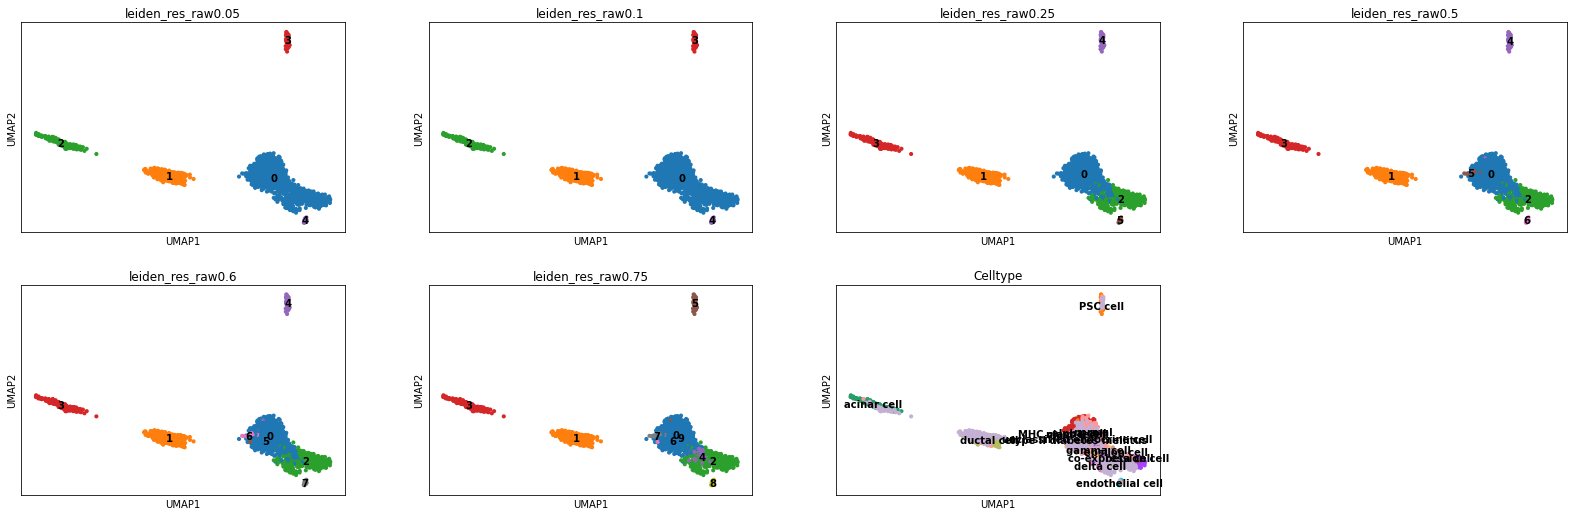

resolution: leiden_res_pc0.05, ARI: 0.40603127148649437, V-measure: 0.6395729974651397, Silhouette score: 0.3741692900657654, Average: 0.4732578530057998
resolution: leiden_res_pc0.1, ARI: 0.6524259420468772, V-measure: 0.78470867216625, Silhouette score: 0.16974028944969177, Average: 0.5356249678876063
resolution: leiden_res_pc0.25, ARI: 0.6587487108720527, V-measure: 0.786660370901288, Silhouette score: 0.17170244455337524, Average: 0.5390371754422386
resolution: leiden_res_pc0.5, ARI: 0.7901379295565352, V-measure: 0.7943998096084053, Silhouette score: 0.17066118121147156, Average: 0.5850663067921373
resolution: leiden_res_pc0.6, ARI: 0.5916170116369831, V-measure: 0.733979028518122, Silhouette score: 0.11628788709640503, Average: 0.48062797575050337
resolution: leiden_res_pc0.75, ARI: 0.6066612994064419, V-measure: 0.7545052767107836, Silhouette score: 0.12194358557462692, Average: 0.4943700538972841
Performing clustering with impute= False, recipe=zheng, harmony_pca=True


2023-04-28 01:36:08,071 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-28 01:36:09,666 - harmonypy - INFO - sklearn.KMeans initialization complete.


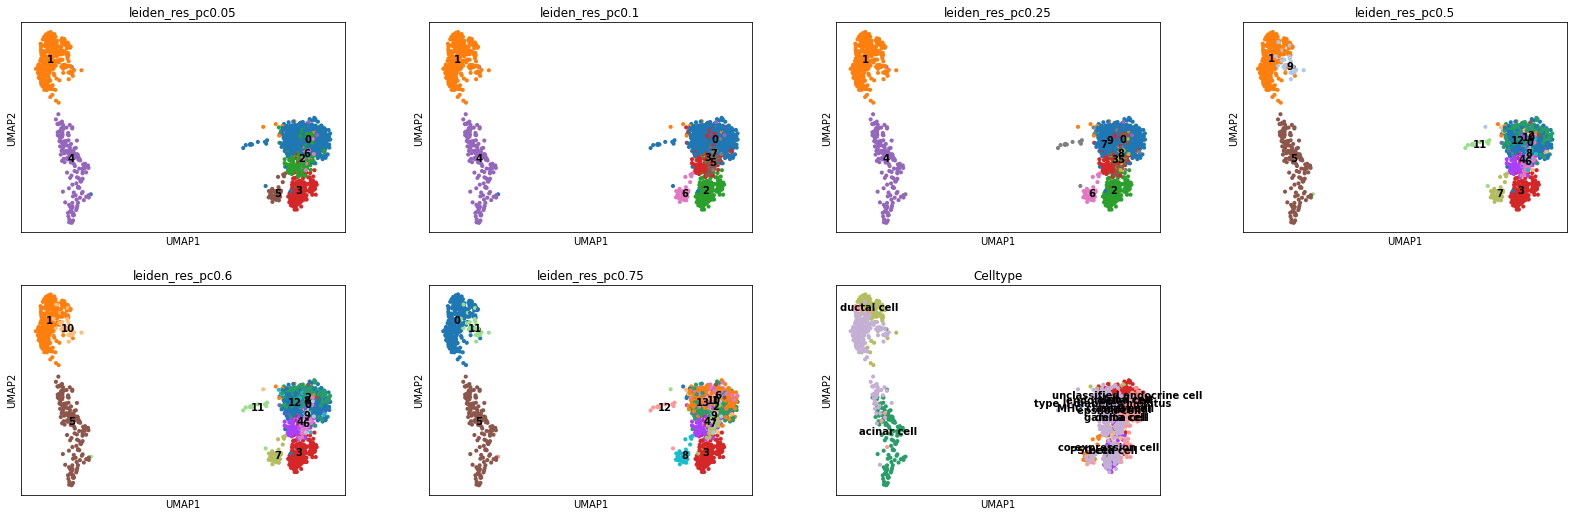

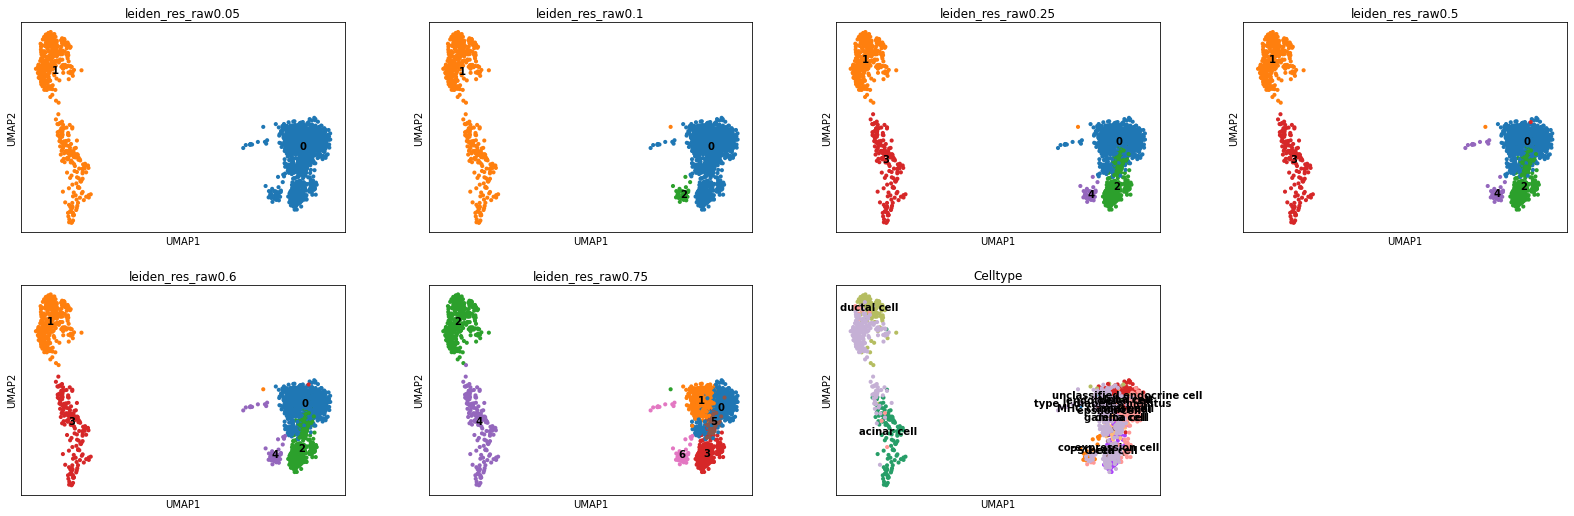

resolution: leiden_res_pc0.05, ARI: 0.8753462276949818, V-measure: 0.8542309445903883, Silhouette score: 0.33183860778808594, Average: 0.6871385933578186
resolution: leiden_res_pc0.1, ARI: 0.8959155351145326, V-measure: 0.8746758724223376, Silhouette score: 0.3459838926792145, Average: 0.7055251000720282
resolution: leiden_res_pc0.25, ARI: 0.9239683154229565, V-measure: 0.8978189738466978, Silhouette score: 0.4077933430671692, Average: 0.7431935441122746
resolution: leiden_res_pc0.5, ARI: 0.6908261599800716, V-measure: 0.8408165512336448, Silhouette score: 0.2673261761665344, Average: 0.599656295793417
resolution: leiden_res_pc0.6, ARI: 0.7016474953317645, V-measure: 0.8419958491971846, Silhouette score: 0.2839781939983368, Average: 0.6092071795090953
resolution: leiden_res_pc0.75, ARI: 0.617495539344927, V-measure: 0.8167164406408547, Silhouette score: 0.2540965974330902, Average: 0.5627695258062907
Performing clustering with impute= False, recipe=zheng, harmony_pca=False


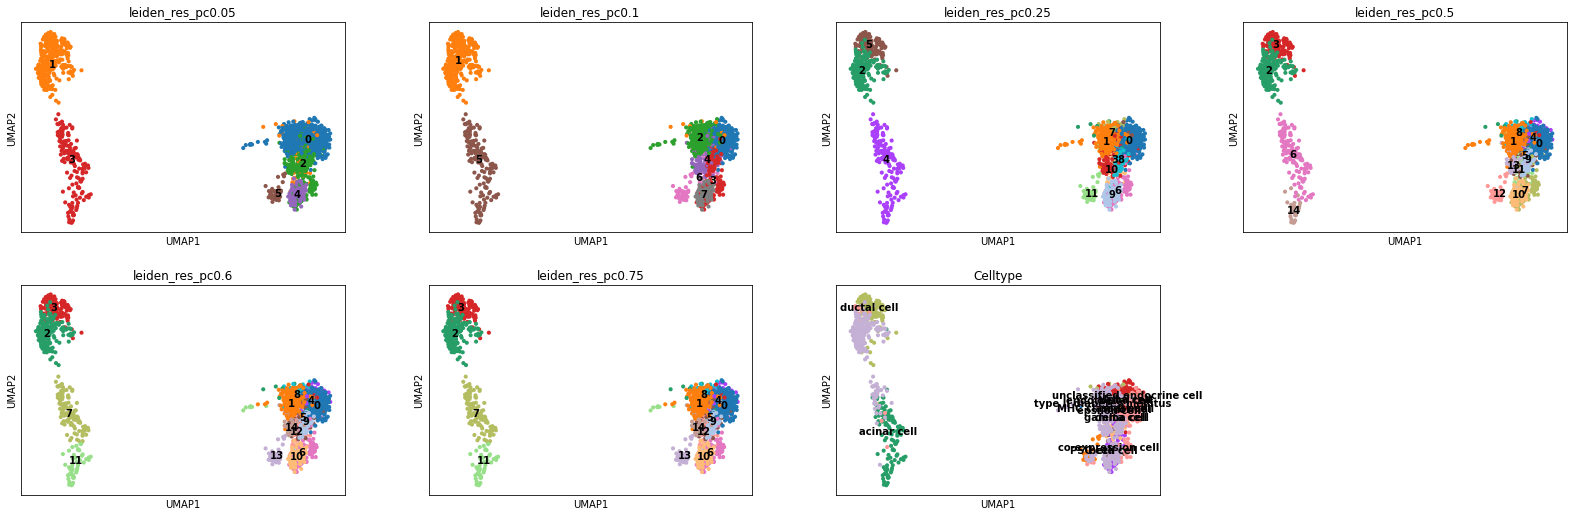

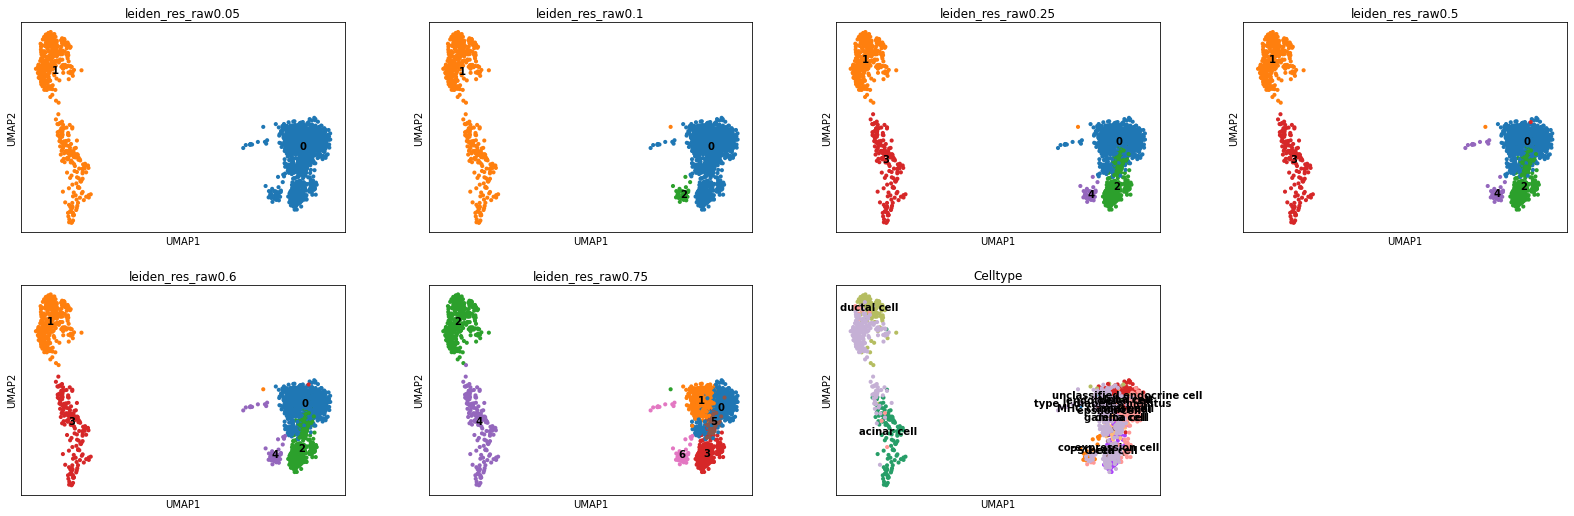

resolution: leiden_res_pc0.05, ARI: 0.8147571641145199, V-measure: 0.7944219944362543, Silhouette score: 0.23385408520698547, Average: 0.6143444145859199
resolution: leiden_res_pc0.1, ARI: 0.7532100842456914, V-measure: 0.8159757368382321, Silhouette score: 0.2269173413515091, Average: 0.5987010541451442
resolution: leiden_res_pc0.25, ARI: 0.7649028873721976, V-measure: 0.8462663622652156, Silhouette score: 0.21957671642303467, Average: 0.6102486553534826
resolution: leiden_res_pc0.5, ARI: 0.5745659495928934, V-measure: 0.7946832640059925, Silhouette score: 0.19040332734584808, Average: 0.5198841803149113
resolution: leiden_res_pc0.6, ARI: 0.5664748353428866, V-measure: 0.7909684674232884, Silhouette score: 0.19227200746536255, Average: 0.5165717700771791
resolution: leiden_res_pc0.75, ARI: 0.5664748353428866, V-measure: 0.7909684674232884, Silhouette score: 0.19227200746536255, Average: 0.5165717700771791
Performing clustering with impute= False, recipe=weinreb, harmony_pca=True


2023-04-28 01:36:36,811 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-28 01:36:38,258 - harmonypy - INFO - sklearn.KMeans initialization complete.


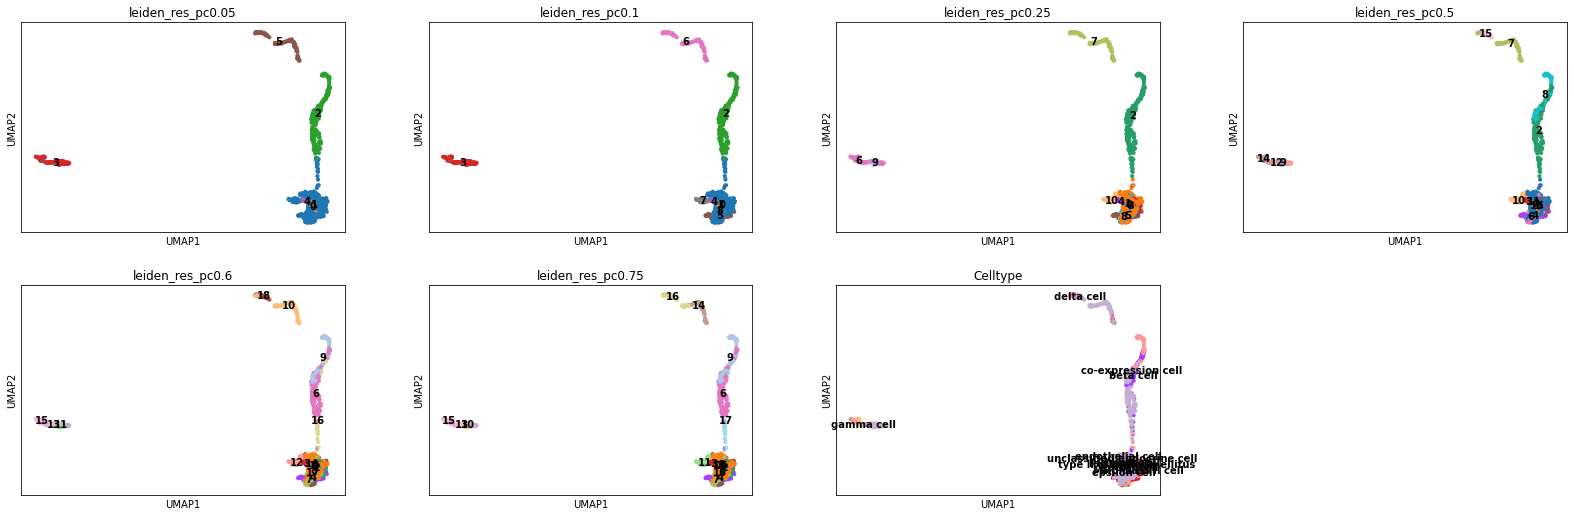

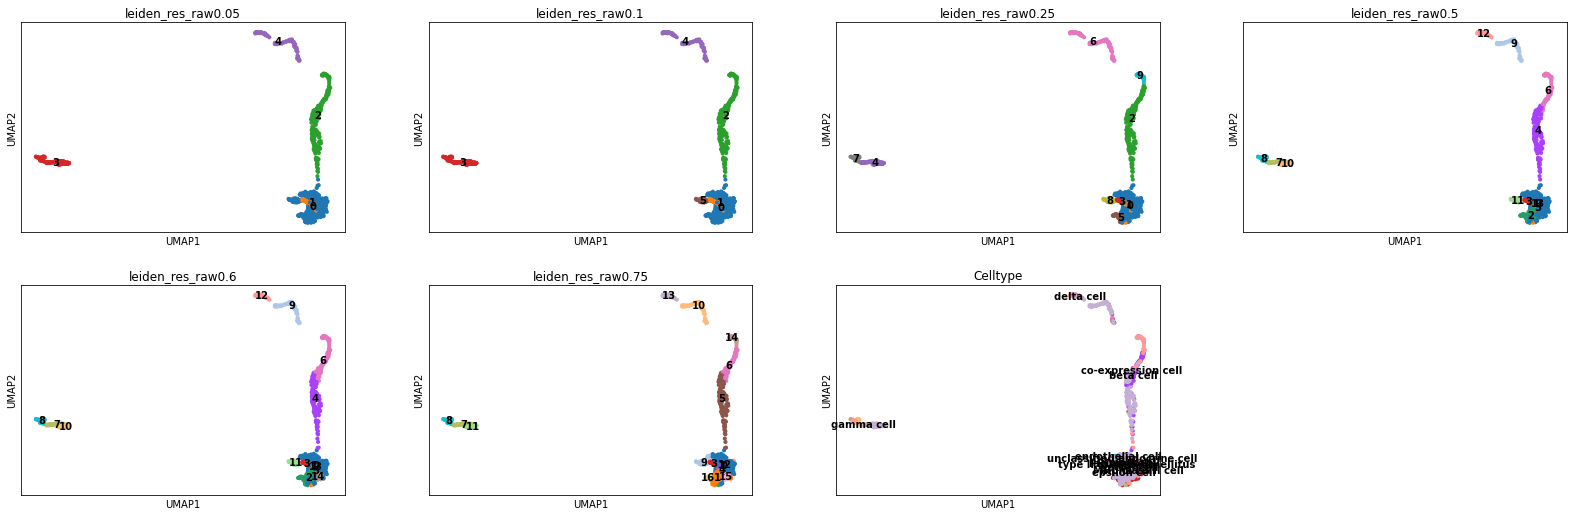

resolution: leiden_res_pc0.05, ARI: 0.7965264998539576, V-measure: 0.8075168722102585, Silhouette score: 0.23447772860527039, Average: 0.6128403668898289
resolution: leiden_res_pc0.1, ARI: 0.64170245397722, V-measure: 0.7725667888274473, Silhouette score: 0.08715267479419708, Average: 0.5004739725329549
resolution: leiden_res_pc0.25, ARI: 0.6219185023891806, V-measure: 0.7751538903385742, Silhouette score: 0.12779922783374786, Average: 0.5082905401871676
resolution: leiden_res_pc0.5, ARI: 0.5398609899942595, V-measure: 0.7320841184227102, Silhouette score: 0.11806890368461609, Average: 0.46333800403386194
resolution: leiden_res_pc0.6, ARI: 0.40336055720974023, V-measure: 0.6920282448276381, Silhouette score: 0.048890773206949234, Average: 0.38142652508144254
resolution: leiden_res_pc0.75, ARI: 0.4032478143120812, V-measure: 0.6930899385554259, Silhouette score: 0.04988112673163414, Average: 0.3820729598663804
Performing clustering with impute= False, recipe=weinreb, harmony_pca=False


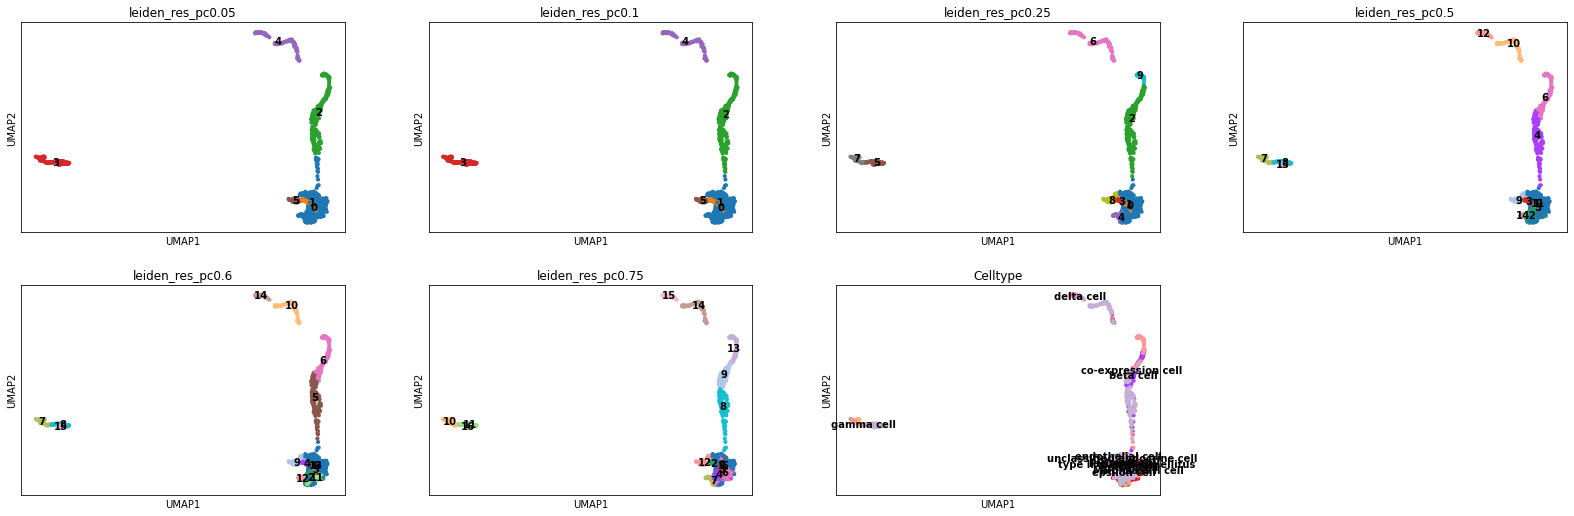

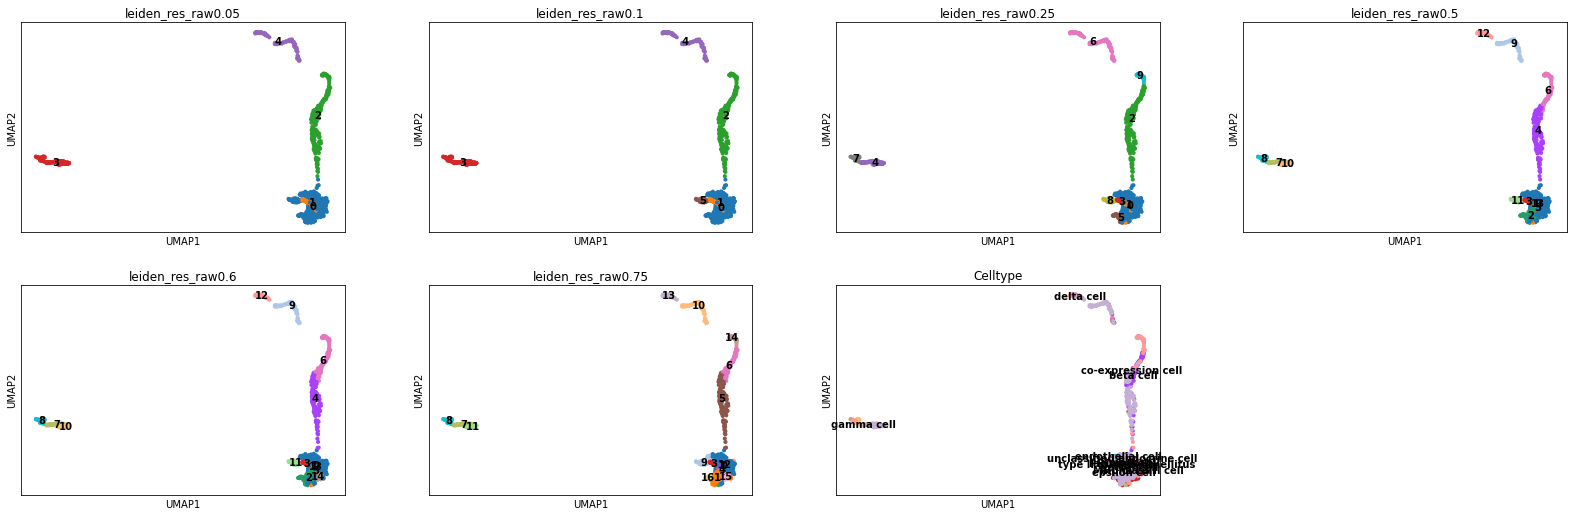

resolution: leiden_res_pc0.05, ARI: 0.7626719516504004, V-measure: 0.7898686152538898, Silhouette score: 0.16085754334926605, Average: 0.571132703417852
resolution: leiden_res_pc0.1, ARI: 0.7752999502082073, V-measure: 0.8034056771451861, Silhouette score: 0.1546478569507599, Average: 0.5777844947680512
resolution: leiden_res_pc0.25, ARI: 0.7356334227694615, V-measure: 0.8143796870873441, Silhouette score: 0.20775558054447174, Average: 0.5859228968004259
resolution: leiden_res_pc0.5, ARI: 0.5567974594638418, V-measure: 0.7494051080983483, Silhouette score: 0.16538628935813904, Average: 0.490529618973443
resolution: leiden_res_pc0.6, ARI: 0.5112128968638411, V-measure: 0.7334790509409613, Silhouette score: 0.15641523897647858, Average: 0.46703572892709366
resolution: leiden_res_pc0.75, ARI: 0.4512002571196725, V-measure: 0.7226574262878293, Silhouette score: 0.11125223338603973, Average: 0.4283699722645138
Performing clustering with impute= False, recipe=basic, harmony_pca=True


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2023-04-28 01:37:03,935 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-28 01:37:05,915 - harmonypy - INFO - sklearn.KMeans initialization complete.


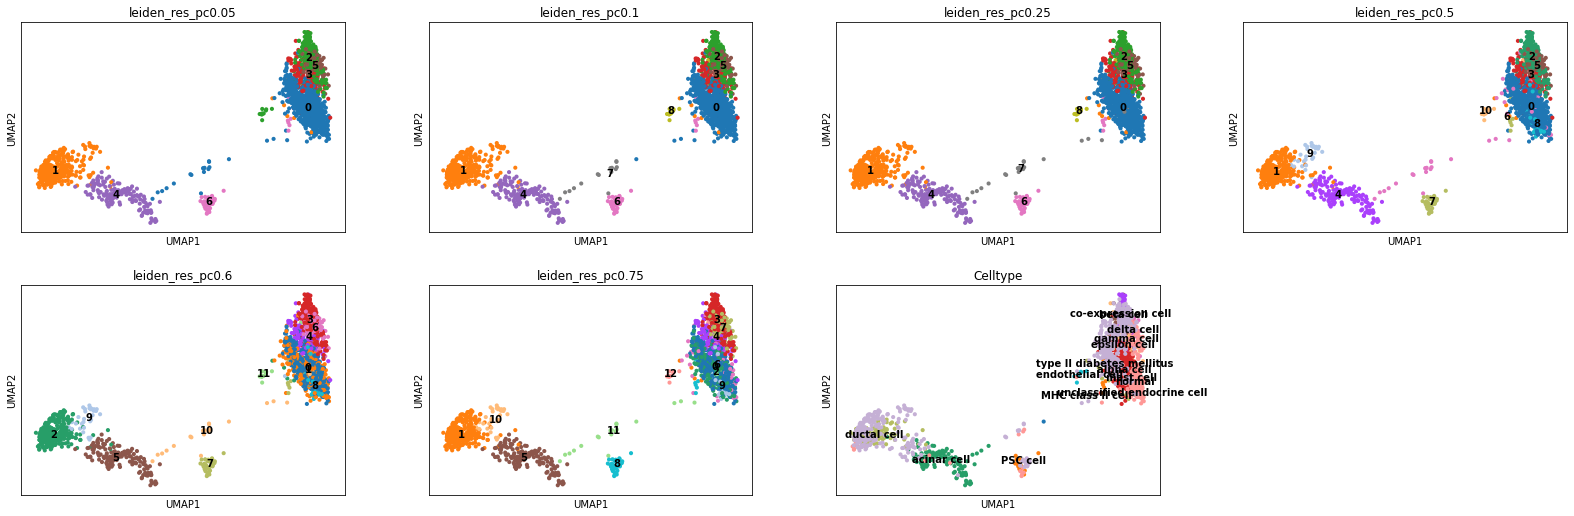

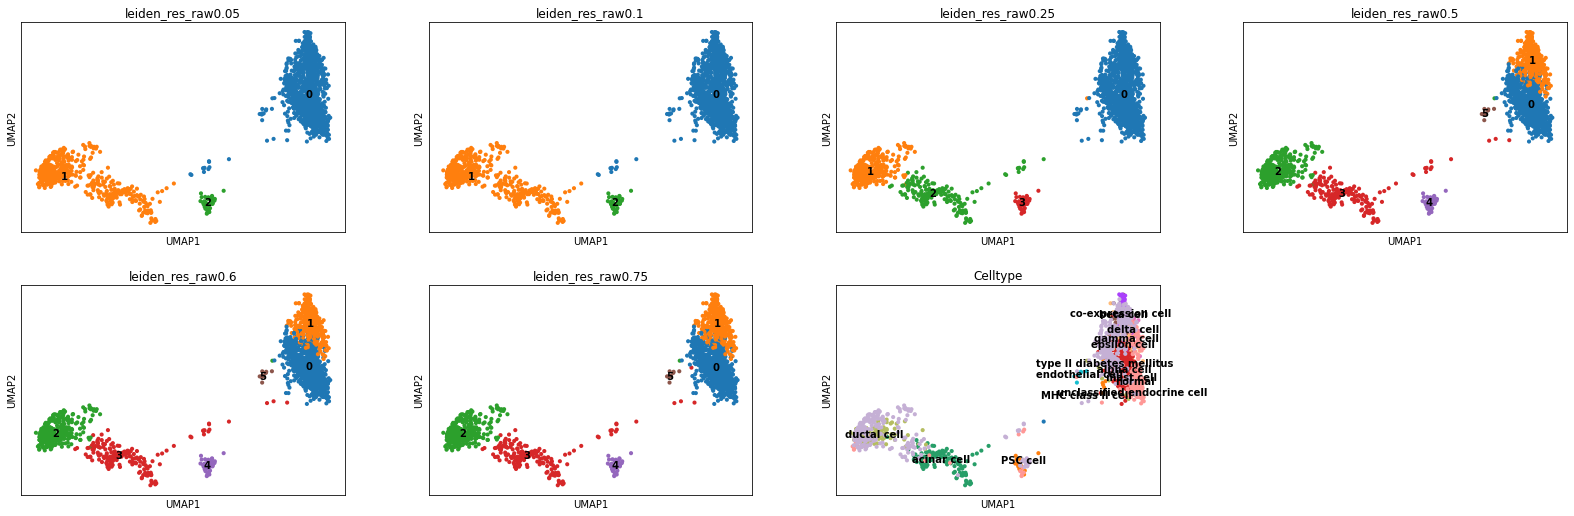

resolution: leiden_res_pc0.05, ARI: 0.905679400792885, V-measure: 0.8964249963526251, Silhouette score: 0.289932519197464, Average: 0.6973456387809914
resolution: leiden_res_pc0.1, ARI: 0.925413593285077, V-measure: 0.9158124624034286, Silhouette score: 0.3320259153842926, Average: 0.7244173236909327
resolution: leiden_res_pc0.25, ARI: 0.9343228748786545, V-measure: 0.920686684837685, Silhouette score: 0.33749905228614807, Average: 0.7308362040008292
resolution: leiden_res_pc0.5, ARI: 0.8833038369048679, V-measure: 0.8793960416306575, Silhouette score: 0.2869880199432373, Average: 0.683229299492921
resolution: leiden_res_pc0.6, ARI: 0.6776313759647197, V-measure: 0.8397672615547566, Silhouette score: 0.21612751483917236, Average: 0.5778420507862162
resolution: leiden_res_pc0.75, ARI: 0.6175787054940084, V-measure: 0.8155697157635997, Silhouette score: 0.20958799123764038, Average: 0.5475788041650828
Performing clustering with impute= False, recipe=basic, harmony_pca=False


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


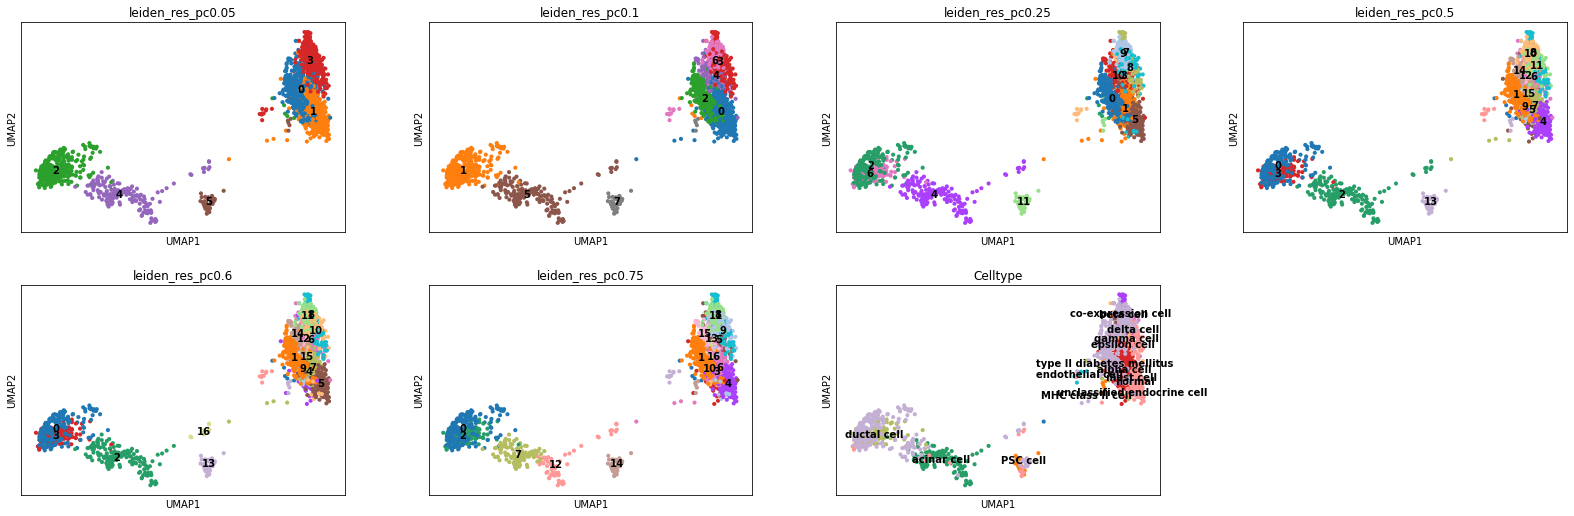

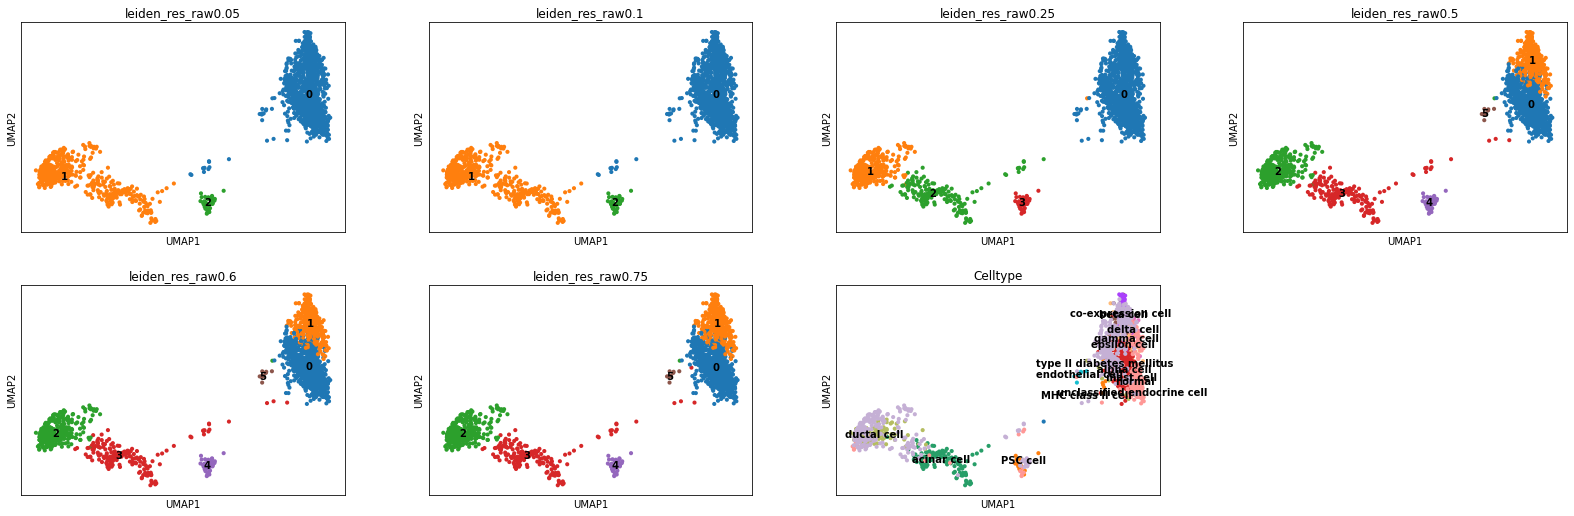

resolution: leiden_res_pc0.05, ARI: 0.6723855242074603, V-measure: 0.7856320271051418, Silhouette score: 0.18932394683361053, Average: 0.5491138327154043
resolution: leiden_res_pc0.1, ARI: 0.7388380856083913, V-measure: 0.8282486067570934, Silhouette score: 0.2178046852350235, Average: 0.5949637925335027
resolution: leiden_res_pc0.25, ARI: 0.697367941663416, V-measure: 0.8192623599356403, Silhouette score: 0.18094411492347717, Average: 0.5658581388408445
resolution: leiden_res_pc0.5, ARI: 0.556873928037293, V-measure: 0.7831549645984384, Silhouette score: 0.19610002636909485, Average: 0.5120429730016087
resolution: leiden_res_pc0.6, ARI: 0.5555596924273052, V-measure: 0.7787303808982792, Silhouette score: 0.180780291557312, Average: 0.5050234549609655
resolution: leiden_res_pc0.75, ARI: 0.5240713761913864, V-measure: 0.7639886028311652, Silhouette score: 0.17173200845718384, Average: 0.4865973291599118
Performing clustering with impute= False, recipe=None, harmony_pca=True


2023-04-28 01:37:31,514 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-28 01:37:33,372 - harmonypy - INFO - sklearn.KMeans initialization complete.


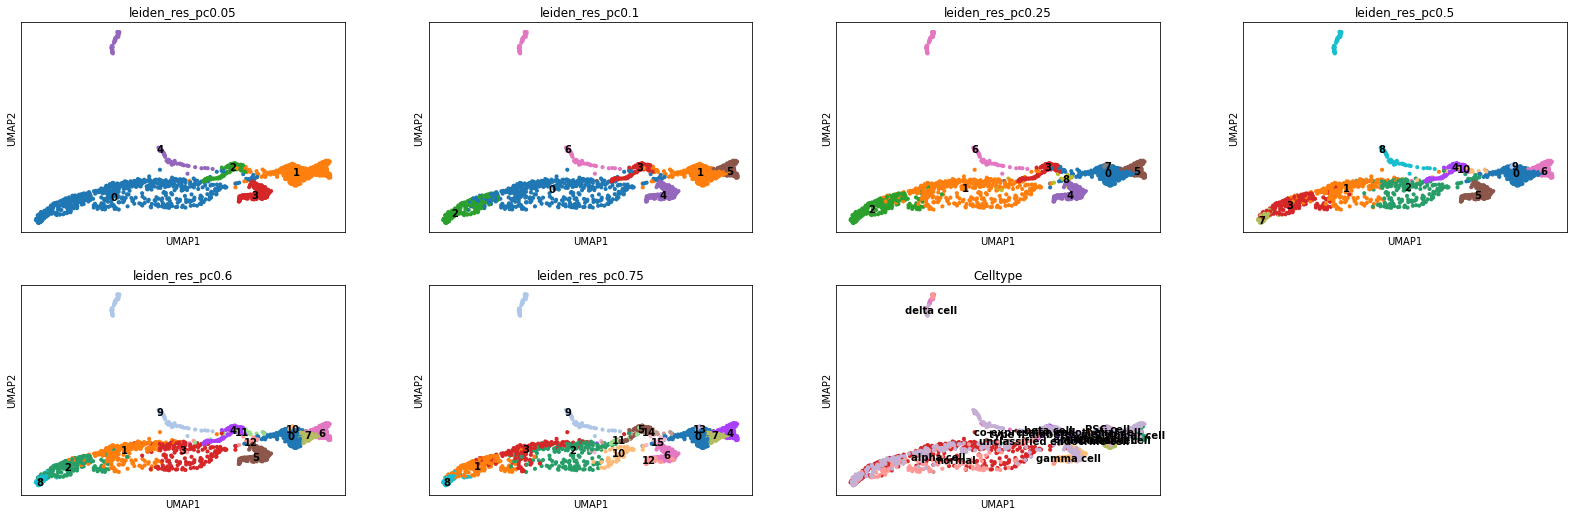

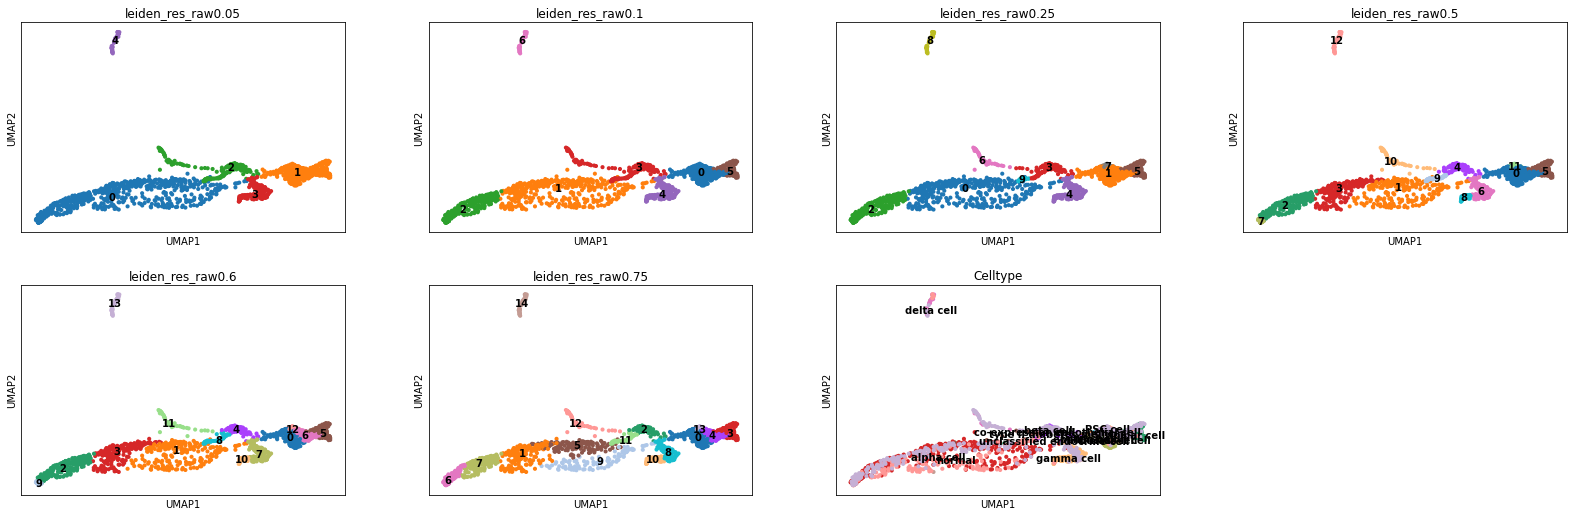

resolution: leiden_res_pc0.05, ARI: 0.7166189520779436, V-measure: 0.7442272433979081, Silhouette score: 0.425234317779541, Average: 0.6286935044184642
resolution: leiden_res_pc0.1, ARI: 0.6488735639133754, V-measure: 0.7607060893303331, Silhouette score: 0.42954501509666443, Average: 0.6130415561134576
resolution: leiden_res_pc0.25, ARI: 0.6575463249877395, V-measure: 0.7811373954578265, Silhouette score: 0.32113900780677795, Average: 0.5866075760841146
resolution: leiden_res_pc0.5, ARI: 0.5229539198570711, V-measure: 0.7426017803131297, Silhouette score: 0.2902586758136749, Average: 0.5186047919946253
resolution: leiden_res_pc0.6, ARI: 0.49154397721838866, V-measure: 0.7347022147997369, Silhouette score: 0.2830793261528015, Average: 0.5031085060569757
resolution: leiden_res_pc0.75, ARI: 0.41589309563183, V-measure: 0.7026346113503278, Silhouette score: 0.26535436511039734, Average: 0.4612940240308517
Performing clustering with impute= False, recipe=None, harmony_pca=False


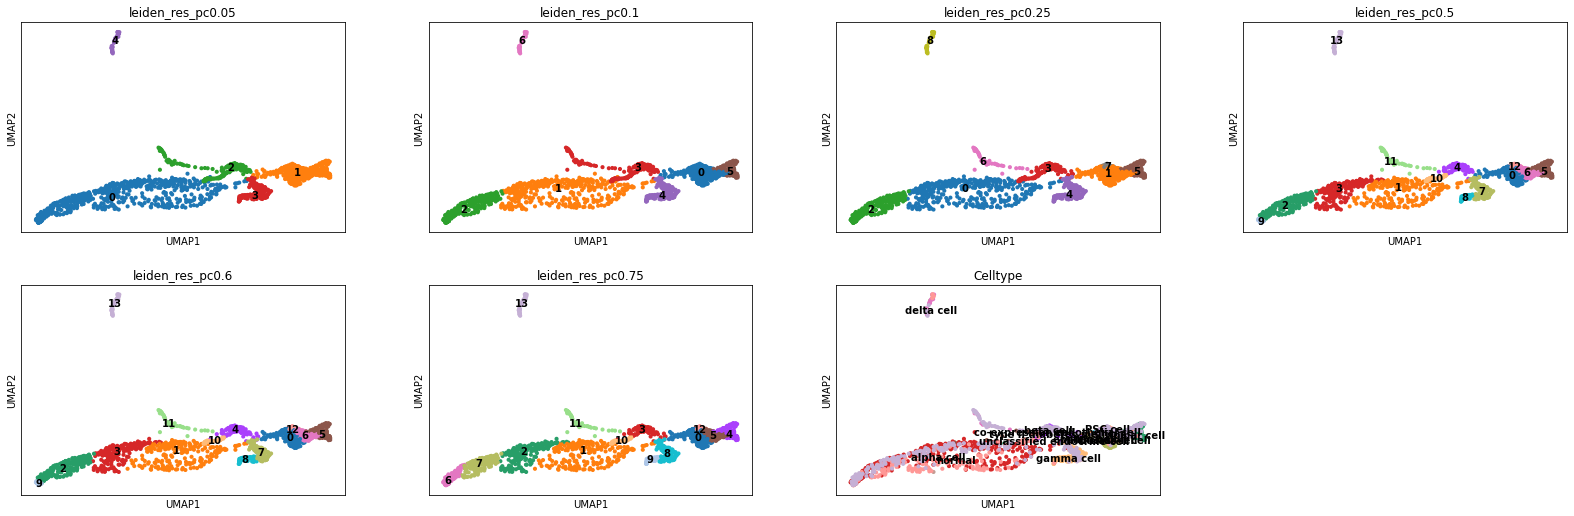

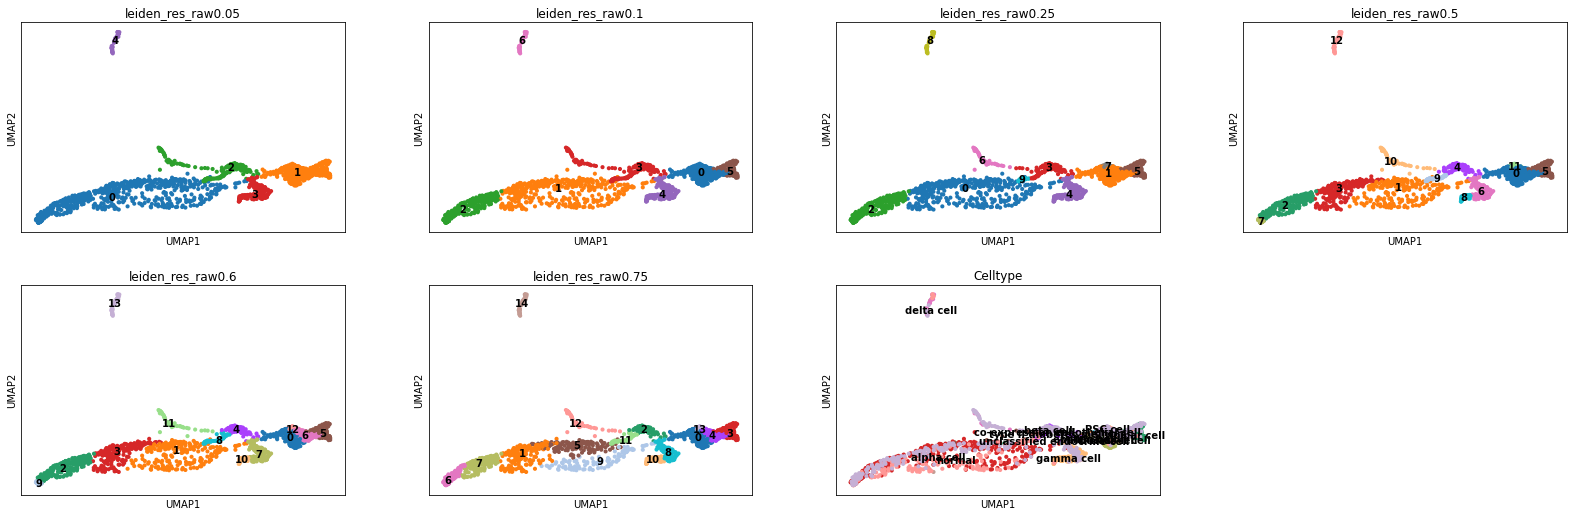

resolution: leiden_res_pc0.05, ARI: 0.7510423733573051, V-measure: 0.7658144051409712, Silhouette score: 0.3736349642276764, Average: 0.6301639142419843
resolution: leiden_res_pc0.1, ARI: 0.6537209305805622, V-measure: 0.7787423095758638, Silhouette score: 0.3840423822402954, Average: 0.6055018741322405
resolution: leiden_res_pc0.25, ARI: 0.6940424733887981, V-measure: 0.8151784289836792, Silhouette score: 0.28865060210227966, Average: 0.5992905014915856
resolution: leiden_res_pc0.5, ARI: 0.4694604151730685, V-measure: 0.7207018549868963, Silhouette score: 0.26140493154525757, Average: 0.4838557339017408
resolution: leiden_res_pc0.6, ARI: 0.4783776924526806, V-measure: 0.7290043437135223, Silhouette score: 0.2594568431377411, Average: 0.48894629310131466
resolution: leiden_res_pc0.75, ARI: 0.46838339922756994, V-measure: 0.7267677576274195, Silhouette score: 0.24867920577526093, Average: 0.4812767875434168


In [ ]:
# Adjust these lists according to the parameters you want to test
imputed = [True, False]
recipe_list = ['seurat', 'zheng', 'weinreb', 'basic', 'None']
harmony_pca_list = [True, False]
leiden_resolution_list = [0.05, 0.1, 0.25, 0.5, 0.6, 0.75]
cluster_leiden = [True, False]
umap = True

results = []
maxavg = 0
maxsil = 0

# create sc_pancreas_metadata_test_fake that includes "test cell type" as a column
sc_pancreas_metadata_test_fake = sc_pancreas_metadata_test.copy()
sc_pancreas_metadata_test_fake['Celltype'] = sc_pancreas_metadata_test_fake['Disease']

# trainsamp = pd.DataFrame(sc_pancreas_metadata[['Sample', 'Disease']], index= sc_pancreas_metadata.index)
# testsamp = pd.DataFrame(sc_pancreas_metadata_test[['Sample', 'Disease']], index= sc_pancreas_metadata_test.index)
metadata_all = pd.concat([sc_pancreas_metadata, sc_pancreas_metadata_test_fake], axis=0)

# Iterate over all combinations of parameters and perform clustering
# adata is of all cells not just train
for impute in imputed:
    if impute:
        adata = sc.AnnData(sc_pancreas_train_test_norm_filt_magic.T)
    else:
        adata = sc.AnnData(sc_pancreas_train_test.T)
    for recipe in recipe_list:
        for harmony_pca in harmony_pca_list:
                print(f'Performing clustering with impute= {impute}, recipe={recipe}, harmony_pca={harmony_pca}')
                
                adata_result = perform_clustering(adata, use_recipe=recipe,
                                            use_harmony_pca=harmony_pca, leiden_resolution=leiden_resolution_list,
                                            sc_pancreas_metadata= metadata_all)
                result = {
                    'adata': adata_result,
                    'seurat_recipe': recipe,
                    'harmony_pca': harmony_pca
                }
                results.append(result)

                if umap:
                    sc.pl.umap(
                    adata_result,
                    color=[ "leiden_res_pc0.05", "leiden_res_pc0.1", "leiden_res_pc0.25", "leiden_res_pc0.5", "leiden_res_pc0.6", "leiden_res_pc0.75",
                           "Celltype"],
                    legend_loc="on data",
                    )

                    sc.pl.umap(
                    adata_result,
                    color=["leiden_res_raw0.05", "leiden_res_raw0.1", "leiden_res_raw0.25", "leiden_res_raw0.5", "leiden_res_raw0.6", "leiden_res_raw0.75",
                           "Celltype"],
                    legend_loc="on data",
                    )

                # calculate scores for each leiden resolution
                for lr in leiden_resolution_list:
                    leiden_key = 'leiden_res_pc' + str(lr)
                    vANDari, silhouette = cluster_scoring(adata_result, leiden_key, sc_pancreas_metadata)
                    # leiden_key_raw = 'leiden_res_raw' + str(lr)
                    # vANDari, silhouette = cluster_scoring(adata_result, leiden_key_raw, sc_pancreas_metadata)

                    if vANDari > maxavg:
                        maxavg = vANDari
                        maximputed = impute
                        maxadata = adata_result
                        maxrecipe = recipe
                        maxharmony_pca = harmony_pca
                        maxleiden_key = lr
                    if silhouette > maxsil:
                        maxsil = silhouette
                        silimputed = impute
                        siladata = adata_result
                        silrecipe = recipe
                        silharmony_pca = harmony_pca
                        silleiden_key = lr

# `results` will now contain the clustering results for all combinations of methods


# Step 3: Predict on the test data

Performing imputation to create imputed_bulkified.csv

In [ ]:
# sc_pancreas_imputed_test = best_magic_operator.transform(sc_pancreas_test)      
sc_pancreas_imputed_test = sc_pancreas_train_test_norm_filt_magic[sc_pancreas_test.columns]
bulkified = bulkification(sc_pancreas_imputed_test)
# bulkified should be a DataFrame containing the "bulkified" version of the imputed data
# turn index into column
bulkified.reset_index(level=0, inplace=True)

bulkified.columns = ["index", "patient5","patient6","patient7"]

### Perform clustering to assign cell cluster membership 

In [ ]:
if maximputed:
    adata_test = sc.AnnData(sc_pancreas_train_test_norm_filt_magic.T)
else:
    adata_test = sc.AnnData(sc_pancreas_train_test.T)

adata_test_cluster = perform_clustering(adata_test, metadata_all, use_recipe= maxrecipe, 
                                        use_harmony_pca= maxharmony_pca, leiden_resolution=maxleiden_key)
maxleiden_key_str = 'leiden_res_pc' + str(maxleiden_key)
cluster_labels = adata_test_cluster.obs[maxleiden_key_str]
cluster_labels = cluster_labels.loc[sc_pancreas_test.columns]

cluster_labels = pd.DataFrame(cluster_labels)
cluster_labels.reset_index(level=0, inplace=True)

2023-04-28 01:40:20,804 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-28 01:40:22,356 - harmonypy - INFO - sklearn.KMeans initialization complete.


### Perform PCA to coordinates of the cells in the test dataset in the 50 first PCs computed on your data

In [ ]:
if silimputed:
    adata_test_sil = sc.AnnData(sc_pancreas_train_test_norm_filt_magic.T)
else:
    adata_test_sil = sc.AnnData(sc_pancreas_train_test.T)

adata_test_sil = perform_clustering(adata_test_sil, metadata_all, use_recipe= silrecipe,
                                    use_harmony_pca= silharmony_pca, leiden_resolution=silleiden_key)
PCA = adata_test_sil.obsm['X_pca'][978:1767,:]
PCA = pd.DataFrame(PCA)
PCA.reset_index(level=0, inplace=True)

# rename columns to be index, PC1, PC2, ... PC50
PCA.columns = ["index"] + ["PC"+str(i+1) for i in range(50)]
PCA["index"] = sc_pancreas_test.columns

2023-04-28 01:42:05,515 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-28 01:42:06,785 - harmonypy - INFO - sklearn.KMeans initialization complete.


# Step 4: Save the required files

In [ ]:
results_path = os.getcwd()
archive_name = "Jung_HuiJeong_Project2-trial.zip" 

In [ ]:
assert all(bulkified.columns == ["index","patient5","patient6","patient7"])

In [ ]:
assert all(bulkified["index"] == sc_pancreas_test.index)

In [ ]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
cluster_labels.columns = ["index", "cluster"]
cluster_labels["index"] = sc_pancreas_test.columns

In [ ]:
assert all(cluster_labels.columns == ["index","cluster"])

In [ ]:
assert all(cluster_labels["index"] == sc_pancreas_test.columns)

In [ ]:
# PCA should be a DataFrame containing the coordinates of each cell in the PCA transformed space for the 50 first PCs
# PCA.columns = ["index", "PC1", "PC2", ..., "PC50"]
# PCA["index"] = sc_pancreas_test.columns

In [ ]:
assert all(PCA.columns == ["index"] + ["PC"+str(i+1) for i in range(50)])

In [ ]:
assert all(PCA["index"] == sc_pancreas_test.columns)

In [ ]:
with zipfile.ZipFile(os.path.join(results_path, archive_name), "x") as zf:
    with zf.open(f"imputed_bulkified.csv", "w") as buffer:
        bulkified.to_csv(buffer)
    with zf.open(f"cluster_membership.csv", "w") as buffer:
        cluster_labels.to_csv(buffer)
    with zf.open(f"PCA.csv", "w") as buffer:
        PCA.to_csv(buffer)
    zf.close()

In [ ]:
archive = zipfile.ZipFile(os.path.join(results_path, archive_name))
assert all(
        [
            i in archive.namelist()
            for i in [
                "imputed_bulkified.csv",
                "cluster_membership.csv",
                "PCA.csv",
            ]
        ]
    )